### ITSM Ticket automation using RNN


1. NLP using LSTM to the Description of the problem
2. Run RNN for the attributes

In [1]:
import keras 
import numpy as np
from keras.preprocessing.text import Tokenizer
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, Flatten
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [2]:
data = pd.read_csv('/Users/jairomelo/Desktop/ML/YORK/ML1030/Capstone Project/incident 05-09-19.csv', encoding = "cp1252")

### Actions:
1. Balance the data sample.
2. Description has null values; we will use short description in case of missing description, and filter any record where no description nor short description is provided
3. Removing any occurence where 

In [3]:
# replacing na values in description with the Short Description 
data["Description"].fillna(data["Short_Description"], inplace = True) 
data = data.dropna(subset = ['KCS_solution'])


In [4]:
data.head()

,Number,Description,Short_Description,Caller,Priority,Category,Sub_Category,Urgency,Impact,Configuration_item,...,Assignment_group,State.1,Resolution_category,Site,Resolved_by_group,Resolved_by,KCS_solution,CI_regions,Created,Resolved
0,INC000017612819,SIMS blank page when open with IE\r\n??IE ??S...,SIMS blank page,YUTONG ZHOU (152062324),Priority 4,Software,Website,Low,Limited,SIMS LATAM,...,GLOBAL SERVICE DESK,Closed Complete,Change Implementation,NaN,GLOBAL SERVICE DESK,JING HUANG (645010504),KB000010025934,LATAM,2017-11-12 21:03,2017-11-12 21:03
1,INC000020585404,"For dim_slt_id=203, dim_task_id=1658 exited wi...",TASK_STATUS - SLT ID 203,AGGRIFY SLT AUTOMATION (702303384),Priority 4,Application,Job Failure,Low,Limited,MENTOR BI SALES ANALYTICS,...,DATA AND ANALYTICS RR LTI,Closed Complete,Job Failure,NA US NJ RARITAN,DATA AND ANALYTICS RR LTI,DILIP KHANDAI (643026421),KB000010080602,NaN,2019-08-04 3:30,2019-08-06 6:39
2,INC000020692831,"For DIM_SLT_ID=203, following task(s) violated...",TASK_END_DELAY violated for DIM_SLT_ID 203,AGGRIFY SLT AUTOMATION (702303384),Priority 4,Application,Poor performance,Low,Limited,MENTOR BI SALES ANALYTICS,...,DATA AND ANALYTICS RR LTI,Draft,Job Failure,NA US NJ RARITAN,DATA AND ANALYTICS RR LTI,DILIP KHANDAI (643026421),KB000010081617,NaN,2019-08-24 2:15,2019-08-28 4:55
4,INC000017291067,> DS huddle Login issue,> DS huddle Login issue,SEAN FOLEY (702113126),Priority 4,Software,Desktop Software,Low,Localized,DS MOBILE,...,GLOBAL SERVICE DESK,Closed Complete,User Access / Permission,NA US NJ RARITAN,GLOBAL SERVICE DESK,ABEGAIL COMON (645001723),KB000010027981,NaN,2017-08-31 10:34,2017-08-31 14:36
6,INC000019116968,When did this issue begin?:2018-09-28\n\nWho i...,not correct data on report. This is follow up ...,THI PHUONG THAO TRAN (152047182),Priority 3,Application,Data Issue,High,Limited,IDISCOVER-OSEA-PROD,...,DATA AND ANALYTICS RR TCS,Closed Complete,Data Issue,ASPAC VN HO CHI MINH CITY,DATA AND ANALYTICS RR TCS,SUREKHA A (643011713),KB000010044712,ASPAC,2018-09-30 22:39,2018-10-03 9:42


In [5]:
data.KCS_solution.value_counts()

KB000010048673    1024
KB000010081174     798
KB000010036182     573
KB000010050747     527
KB000010046825     473
KB000010043597     439
KB000010025911     410
KB000010078359     359
KB000010049766     339
KB000010041363     278
KB000010032380     262
KB000010052516     227
KB000010057276     219
KB000010026638     172
KB000010081617     160
KB000010049545     159
KB000010057501     135
KB000010079000     128
KB000010045971     117
KB000010028903     115
KB000010049422     112
KB000010079222     111
KB000010079700     107
KB000010052515     105
KB000010048910     105
KB000010032297     103
KB000010024976     102
KB000010033441      96
KB000010058918      95
KB000010026470      95
                  ... 
KB000010069624       1
KB000010045745       1
KB000010053727       1
KB000010068770       1
KB000010040516       1
KB000010055505       1
KB000010049188       1
KB000010061540       1
KB000010048198       1
KB000010044589       1
KB000010045439       1
KB000010049614       1
KB000010066

In [6]:
data['target_KCS'] = data.KCS_solution.astype('category').cat.codes

In [7]:
labels = data.KCS_solution.astype('category').cat.categories

In [8]:
df = pd.DataFrame(labels) 
df.to_csv ('/Users/jairomelo/Desktop/ML/YORK/ML1030/Capstone Project/labels_KCS.csv')


In [9]:
data.head()

,Number,Description,Short_Description,Caller,Priority,Category,Sub_Category,Urgency,Impact,Configuration_item,...,State.1,Resolution_category,Site,Resolved_by_group,Resolved_by,KCS_solution,CI_regions,Created,Resolved,target_KCS
0,INC000017612819,SIMS blank page when open with IE\r\n??IE ??S...,SIMS blank page,YUTONG ZHOU (152062324),Priority 4,Software,Website,Low,Limited,SIMS LATAM,...,Closed Complete,Change Implementation,NaN,GLOBAL SERVICE DESK,JING HUANG (645010504),KB000010025934,LATAM,2017-11-12 21:03,2017-11-12 21:03,134
1,INC000020585404,"For dim_slt_id=203, dim_task_id=1658 exited wi...",TASK_STATUS - SLT ID 203,AGGRIFY SLT AUTOMATION (702303384),Priority 4,Application,Job Failure,Low,Limited,MENTOR BI SALES ANALYTICS,...,Closed Complete,Job Failure,NA US NJ RARITAN,DATA AND ANALYTICS RR LTI,DILIP KHANDAI (643026421),KB000010080602,NaN,2019-08-04 3:30,2019-08-06 6:39,6569
2,INC000020692831,"For DIM_SLT_ID=203, following task(s) violated...",TASK_END_DELAY violated for DIM_SLT_ID 203,AGGRIFY SLT AUTOMATION (702303384),Priority 4,Application,Poor performance,Low,Limited,MENTOR BI SALES ANALYTICS,...,Draft,Job Failure,NA US NJ RARITAN,DATA AND ANALYTICS RR LTI,DILIP KHANDAI (643026421),KB000010081617,NaN,2019-08-24 2:15,2019-08-28 4:55,6662
4,INC000017291067,> DS huddle Login issue,> DS huddle Login issue,SEAN FOLEY (702113126),Priority 4,Software,Desktop Software,Low,Localized,DS MOBILE,...,Closed Complete,User Access / Permission,NA US NJ RARITAN,GLOBAL SERVICE DESK,ABEGAIL COMON (645001723),KB000010027981,NaN,2017-08-31 10:34,2017-08-31 14:36,233
6,INC000019116968,When did this issue begin?:2018-09-28\n\nWho i...,not correct data on report. This is follow up ...,THI PHUONG THAO TRAN (152047182),Priority 3,Application,Data Issue,High,Limited,IDISCOVER-OSEA-PROD,...,Closed Complete,Data Issue,ASPAC VN HO CHI MINH CITY,DATA AND ANALYTICS RR TCS,SUREKHA A (643011713),KB000010044712,ASPAC,2018-09-30 22:39,2018-10-03 9:42,1269


In [10]:
data['num_words'] = data['Description'].apply(lambda x : len(x.split()))

In [32]:
bins=[0,50,75, np.inf]
data['bins']=pd.cut(data.num_words, bins=[0,10,30,70,135, np.inf], labels=['0-10', '10-30', '30-70','70-135' ,'>135'])


In [33]:
word_distribution = data.groupby('bins').size().reset_index().rename(columns={0:'counts'})

In [34]:
word_distribution.head()

,bins,counts
0,0-10,6443
1,10-30,5191
2,30-70,5325
3,70-135,3330
4,>135,8950


Text(0.5, 1.0, 'Word distribution per bin')

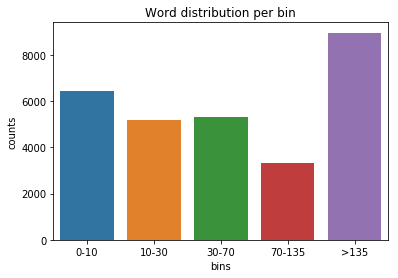

In [35]:
sns.barplot(x='bins', y='counts', data=word_distribution).set_title("Word distribution per bin")

In [36]:
data.head()

,Number,Description,Short_Description,Caller,Priority,Category,Sub_Category,Urgency,Impact,Configuration_item,...,Site,Resolved_by_group,Resolved_by,KCS_solution,CI_regions,Created,Resolved,target_KCS,num_words,bins
0,INC000017612819,SIMS blank page when open with IE\r\n??IE ??S...,SIMS blank page,YUTONG ZHOU (152062324),Priority 4,Software,Website,Low,Limited,SIMS LATAM,...,NaN,GLOBAL SERVICE DESK,JING HUANG (645010504),KB000010025934,LATAM,2017-11-12 21:03,2017-11-12 21:03,134,10,0-10
1,INC000020585404,"For dim_slt_id=203, dim_task_id=1658 exited wi...",TASK_STATUS - SLT ID 203,AGGRIFY SLT AUTOMATION (702303384),Priority 4,Application,Job Failure,Low,Limited,MENTOR BI SALES ANALYTICS,...,NA US NJ RARITAN,DATA AND ANALYTICS RR LTI,DILIP KHANDAI (643026421),KB000010080602,NaN,2019-08-04 3:30,2019-08-06 6:39,6569,8,0-10
2,INC000020692831,"For DIM_SLT_ID=203, following task(s) violated...",TASK_END_DELAY violated for DIM_SLT_ID 203,AGGRIFY SLT AUTOMATION (702303384),Priority 4,Application,Poor performance,Low,Limited,MENTOR BI SALES ANALYTICS,...,NA US NJ RARITAN,DATA AND ANALYTICS RR LTI,DILIP KHANDAI (643026421),KB000010081617,NaN,2019-08-24 2:15,2019-08-28 4:55,6662,20,10-30
4,INC000017291067,> DS huddle Login issue,> DS huddle Login issue,SEAN FOLEY (702113126),Priority 4,Software,Desktop Software,Low,Localized,DS MOBILE,...,NA US NJ RARITAN,GLOBAL SERVICE DESK,ABEGAIL COMON (645001723),KB000010027981,NaN,2017-08-31 10:34,2017-08-31 14:36,233,5,0-10
6,INC000019116968,When did this issue begin?:2018-09-28\n\nWho i...,not correct data on report. This is follow up ...,THI PHUONG THAO TRAN (152047182),Priority 3,Application,Data Issue,High,Limited,IDISCOVER-OSEA-PROD,...,ASPAC VN HO CHI MINH CITY,DATA AND ANALYTICS RR TCS,SUREKHA A (643011713),KB000010044712,ASPAC,2018-09-30 22:39,2018-10-03 9:42,1269,77,70-135


In [37]:
num_class_KCS = len(np.unique(data.KCS_solution.values))
y_KCS = data['target_KCS'].values

## Topic Modelling

In [38]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import numpy as np
import pandas as pd
import re
import warnings
from sklearn.metrics import confusion_matrix
#Visualisation
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from IPython.display import display
#from mpl_toolkits.basemap import Basemap
from wordcloud import WordCloud, STOPWORDS

#nltk
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize

In [39]:
data['Description'] = data['Description'].astype(str)

In [40]:
type(data['Description'])

pandas.core.series.Series

In [41]:
data_description = data.Description.values

In [42]:
type(data_description)

numpy.ndarray

In [43]:
#cv = # Initialize a CountVectorizer object: count_vectorizer
count_vec = CountVectorizer(stop_words="english", analyzer='word', 
                            ngram_range=(1, 1), max_df=1, min_df=1, max_features=None)

# convert text data into term-frequency matrix
data_description = count_vec.fit_transform(data_description)




tfidf_transformer = TfidfTransformer()

# convert term-frequency matrix into tf-idf
tfidf_matrix = tfidf_transformer.fit_transform(data_description)

# create dictionary to find a tfidf word each word
word2tfidf = dict(zip(count_vec.get_feature_names(), tfidf_transformer.idf_))

for word, score in word2tfidf.items():
    print(word, score)

0000 10.59014573330377
00000 10.59014573330377
000000000000080001 10.59014573330377
000000000000080002 10.59014573330377
000000000000080003 10.59014573330377
000000000000080004 10.59014573330377
000000000000080005 10.59014573330377
000000000000080006 10.59014573330377
000000000000080007 10.59014573330377
000000000000080008 10.59014573330377
000000000000080009 10.59014573330377
000000000000080010 10.59014573330377
000000000000080011 10.59014573330377
000000000000080015 10.59014573330377
000000000000080018 10.59014573330377
000000000000080019 10.59014573330377
000000000000080020 10.59014573330377
000000000000080021 10.59014573330377
000000000000080022 10.59014573330377
000000000000080023 10.59014573330377
000000000000080024 10.59014573330377
000000000000080025 10.59014573330377
000000000000080026 10.59014573330377
000000000000080027 10.59014573330377
000000000000080028 10.59014573330377
000000000000080029 10.59014573330377
000000000000080030 10.59014573330377
000000000000080033 10.590145

002663 10.59014573330377
00268336 10.59014573330377
0027 10.59014573330377
0028 10.59014573330377
002870 10.59014573330377
002888 10.59014573330377
0029 10.59014573330377
002970 10.59014573330377
0029m 10.59014573330377
0030 10.59014573330377
00300450242136 10.59014573330377
00300450242259 10.59014573330377
00300450295095 10.59014573330377
00300450488404 10.59014573330377
0030130363 10.59014573330377
0030130364 10.59014573330377
0030130365 10.59014573330377
0030130453 10.59014573330377
0030130456 10.59014573330377
0030131040 10.59014573330377
0030167413 10.59014573330377
0030223600 10.59014573330377
0030248469 10.59014573330377
0030249220 10.59014573330377
003059173 10.59014573330377
00312547780216 10.59014573330377
0032 10.59014573330377
003243 10.59014573330377
003357 10.59014573330377
003442 10.59014573330377
003450 10.59014573330377
0036f000026kbsf 10.59014573330377
0036f00002eq3hu 10.59014573330377
0037h 10.59014573330377
0037hbn 10.59014573330377
00381370024897 10.59014573330377


048wu 10.59014573330377
048wy 10.59014573330377
048zs 10.59014573330377
048zv 10.59014573330377
04906 10.59014573330377
0490d 10.59014573330377
0490h 10.59014573330377
0490o 10.59014573330377
0490v 10.59014573330377
04910 10.59014573330377
049c7 10.59014573330377
049c8 10.59014573330377
049eg 10.59014573330377
049g1 10.59014573330377
049s7 10.59014573330377
04a9c 10.59014573330377
04aj7 10.59014573330377
04am5 10.59014573330377
04aw1 10.59014573330377
04b0d 10.59014573330377
04b6k 10.59014573330377
04bct 10.59014573330377
04bpe 10.59014573330377
04bre 10.59014573330377
04c25e52efd64a8596f7c7ec91a7140a 10.59014573330377
04c76a852e96f6a08411ff3ce429ae29 10.59014573330377
04cvc 10.59014573330377
04cvg 10.59014573330377
04cvh 10.59014573330377
04cz6 10.59014573330377
04czd 10.59014573330377
04dak 10.59014573330377
04deb 10.59014573330377
04dnd 10.59014573330377
04doa 10.59014573330377
04dqa 10.59014573330377
04etd 10.59014573330377
04eth 10.59014573330377
04ex0 10.59014573330377
04faq 10.5

0744v 10.59014573330377
0744y 10.59014573330377
0745y 10.59014573330377
0745z 10.59014573330377
074g6 10.59014573330377
074g9 10.59014573330377
074ge 10.59014573330377
074gf 10.59014573330377
074hj 10.59014573330377
074id 10.59014573330377
074iv 10.59014573330377
074iz 10.59014573330377
074jk 10.59014573330377
074k5 10.59014573330377
074kk 10.59014573330377
074kx 10.59014573330377
074l1 10.59014573330377
074l3 10.59014573330377
074l7 10.59014573330377
074l9 10.59014573330377
074lu 10.59014573330377
074lv 10.59014573330377
074m4 10.59014573330377
074mg 10.59014573330377
07518 10.59014573330377
0758q 10.59014573330377
0758t 10.59014573330377
075di 10.59014573330377
075dy 10.59014573330377
075h7 10.59014573330377
0761n 10.59014573330377
0761r 10.59014573330377
0761v 10.59014573330377
0761w 10.59014573330377
076aa 10.59014573330377
077gj 10.59014573330377
077ys 10.59014573330377
078 10.59014573330377
0788c 10.59014573330377
078oe 10.59014573330377
078v6 10.59014573330377
0793v 10.590145733

09cv0 10.59014573330377
09cy1 10.59014573330377
09dmh 10.59014573330377
09dnf 10.59014573330377
09dng 10.59014573330377
09dnh 10.59014573330377
09dq0 10.59014573330377
09f2x 10.59014573330377
09f6s 10.59014573330377
09f8f 10.59014573330377
09f8h 10.59014573330377
09f8j 10.59014573330377
09f8n 10.59014573330377
09fdr 10.59014573330377
09fe1 10.59014573330377
09fek 10.59014573330377
09fg3 10.59014573330377
09fh2 10.59014573330377
09gc1 10.59014573330377
09gc3 10.59014573330377
09gc6 10.59014573330377
09ggn 10.59014573330377
09gn0 10.59014573330377
09h5d 10.59014573330377
09h5f 10.59014573330377
09heq 10.59014573330377
09hfp 10.59014573330377
09hfs 10.59014573330377
09hft 10.59014573330377
09hfx 10.59014573330377
09hfy 10.59014573330377
09hlb 10.59014573330377
09hnq 10.59014573330377
09hns 10.59014573330377
09hp7 10.59014573330377
09hp8 10.59014573330377
09hp9 10.59014573330377
09hpa 10.59014573330377
09hpb 10.59014573330377
09hpd 10.59014573330377
09i1s 10.59014573330377
09i1t 10.5901457

0bk87 10.59014573330377
0bkao 10.59014573330377
0bkav 10.59014573330377
0bkcu 10.59014573330377
0bkd3 10.59014573330377
0bke0 10.59014573330377
0bkvr 10.59014573330377
0bl46 10.59014573330377
0bndp 10.59014573330377
0bpnx 10.59014573330377
0bq3j 10.59014573330377
0bq3y 10.59014573330377
0bq44 10.59014573330377
0bq4j 10.59014573330377
0bqb0 10.59014573330377
0bqb3 10.59014573330377
0bqb4 10.59014573330377
0bqb8 10.59014573330377
0bqb9 10.59014573330377
0bqhe 10.59014573330377
0bqhg 10.59014573330377
0brcq 10.59014573330377
0bris 10.59014573330377
0bruc 10.59014573330377
0brw0 10.59014573330377
0brw1 10.59014573330377
0brza 10.59014573330377
0bsgw 10.59014573330377
0bsgy 10.59014573330377
0bsvv 10.59014573330377
0bsyc 10.59014573330377
0bt07 10.59014573330377
0bt1o 10.59014573330377
0btdt 10.59014573330377
0bubc 10.59014573330377
0bvrm 10.59014573330377
0bxsh 10.59014573330377
0bxsj 10.59014573330377
0bxsn 10.59014573330377
0bxu9 10.59014573330377
0bxub 10.59014573330377
0by60 10.5901457

0ho22 10.59014573330377
0ho28 10.59014573330377
0ho2s 10.59014573330377
0hoyb 10.59014573330377
0hrtw 10.59014573330377
0hrxe 10.59014573330377
0hrxg 10.59014573330377
0hrxi 10.59014573330377
0hrxl 10.59014573330377
0hrxs 10.59014573330377
0hrxu 10.59014573330377
0hrz2 10.59014573330377
0hs2m 10.59014573330377
0hu21 10.59014573330377
0hu2a 10.59014573330377
0hu2y 10.59014573330377
0hwni 10.59014573330377
0hwns 10.59014573330377
0hwnu 10.59014573330377
0hzx3 10.59014573330377
0i02h 10.59014573330377
0i03s 10.59014573330377
0i07m 10.59014573330377
0i28g 10.59014573330377
0i29k 10.59014573330377
0i2k5 10.59014573330377
0i3lu 10.59014573330377
0i3lv 10.59014573330377
0i3m2 10.59014573330377
0i4nd 10.59014573330377
0i4pc 10.59014573330377
0i4pw 10.59014573330377
0i4sb 10.59014573330377
0i816 10.59014573330377
0i81a 10.59014573330377
0i85u 10.59014573330377
0i85w 10.59014573330377
0i864 10.59014573330377
0i866 10.59014573330377
0i868 10.59014573330377
0i87f 10.59014573330377
0i894 10.5901457

0mr6m 10.59014573330377
0mr7r 10.59014573330377
0mr7z 10.59014573330377
0mr8r 10.59014573330377
0mr8t 10.59014573330377
0mr95 10.59014573330377
0mrej 10.59014573330377
0mrel 10.59014573330377
0ms1i 10.59014573330377
0ms1k 10.59014573330377
0msw4 10.59014573330377
0msw7 10.59014573330377
0mswa 10.59014573330377
0mswd 10.59014573330377
0mt8y 10.59014573330377
0mt93 10.59014573330377
0mtro 10.59014573330377
0mufh 10.59014573330377
0muoa 10.59014573330377
0mv54 10.59014573330377
0mxm5 10.59014573330377
0mxv1 10.59014573330377
0my57 10.59014573330377
0mygm 10.59014573330377
0mz22 10.59014573330377
0mz23 10.59014573330377
0mzfe 10.59014573330377
0mzfl 10.59014573330377
0mzg0 10.59014573330377
0mzg2 10.59014573330377
0n0h8 10.59014573330377
0n0i1 10.59014573330377
0n0ib 10.59014573330377
0n0jp 10.59014573330377
0n0kd 10.59014573330377
0n0kg 10.59014573330377
0n0kj 10.59014573330377
0n0km 10.59014573330377
0n0kp 10.59014573330377
0n18y 10.59014573330377
0n1rq 10.59014573330377
0n2h5 10.5901457

0ui3s 10.59014573330377
0ui3x 10.59014573330377
0uimt 10.59014573330377
0uimz 10.59014573330377
0uin0 10.59014573330377
0uinv 10.59014573330377
0uivc 10.59014573330377
0uj7d 10.59014573330377
0ujod 10.59014573330377
0ujp9 10.59014573330377
0ukhv 10.59014573330377
0ukid 10.59014573330377
0ukii 10.59014573330377
0ukim 10.59014573330377
0ukio 10.59014573330377
0ukja 10.59014573330377
0ukla 10.59014573330377
0ukr7 10.59014573330377
0uks8 10.59014573330377
0ulom 10.59014573330377
0ulon 10.59014573330377
0ummr 10.59014573330377
0unbj 10.59014573330377
0ungc 10.59014573330377
0ungi 10.59014573330377
0unn7 10.59014573330377
0unn8 10.59014573330377
0unn9 10.59014573330377
0unnb 10.59014573330377
0unnc 10.59014573330377
0unnd 10.59014573330377
0unne 10.59014573330377
0unpz 10.59014573330377
0unq8 10.59014573330377
0unql 10.59014573330377
0uns8 10.59014573330377
0unst 10.59014573330377
0unvn 10.59014573330377
0unvw 10.59014573330377
0unvy 10.59014573330377
0upk7 10.59014573330377
0urnp 10.5901457

10161231756 10.59014573330377
1016221 10.59014573330377
1016373 10.59014573330377
1016588 10.59014573330377
1017034 10.59014573330377
10172 10.59014573330377
1017570 10.59014573330377
1017712 10.59014573330377
101jd 10.59014573330377
101k 10.59014573330377
101kc 10.59014573330377
101kl 10.59014573330377
101lz 10.59014573330377
101m6 10.59014573330377
101nk 10.59014573330377
101nu 10.59014573330377
101ro 10.59014573330377
101rq 10.59014573330377
101rx 10.59014573330377
101sa 10.59014573330377
101t0 10.59014573330377
101t2 10.59014573330377
101tb 10.59014573330377
101tr 10.59014573330377
101uq 10.59014573330377
101vr 10.59014573330377
101yq 10.59014573330377
10200 10.59014573330377
10202325 10.59014573330377
10206 10.59014573330377
10207 10.59014573330377
1021 10.59014573330377
102149 10.59014573330377
1022135 10.59014573330377
10223 10.59014573330377
10242464 10.59014573330377
1024812 10.59014573330377
102490 10.59014573330377
1024913 10.59014573330377
1025 10.59014573330377
1027160 10.

1386 10.59014573330377
1387 10.59014573330377
1388 10.59014573330377
13882205122 10.59014573330377
138ol 10.59014573330377
138zs 10.59014573330377
138zz 10.59014573330377
139 10.59014573330377
13907 10.59014573330377
13915981547 10.59014573330377
13917250434 10.59014573330377
13922371244 10.59014573330377
1395 10.59014573330377
13962 10.59014573330377
139d 10.59014573330377
13b4g 10.59014573330377
13d10 10.59014573330377
13d86 10.59014573330377
13dgj 10.59014573330377
13dh7 10.59014573330377
13dhd 10.59014573330377
13dic 10.59014573330377
13dm5 10.59014573330377
13dqh 10.59014573330377
13e1m 10.59014573330377
13fct 10.59014573330377
13fds 10.59014573330377
13fe1 10.59014573330377
13fes 10.59014573330377
13fiw 10.59014573330377
13fkp 10.59014573330377
13flw 10.59014573330377
13fm5 10.59014573330377
13fm7 10.59014573330377
13fme 10.59014573330377
13fmg 10.59014573330377
13fmr 10.59014573330377
13fmw 10.59014573330377
13fnv 10.59014573330377
13g6e 10.59014573330377
13g6h 10.59014573330377

15rd4 10.59014573330377
15rhl 10.59014573330377
15rpj 10.59014573330377
15rr0 10.59014573330377
15rsm 10.59014573330377
15rtc 10.59014573330377
15sdv 10.59014573330377
15si1 10.59014573330377
15si7 10.59014573330377
15t16 10.59014573330377
15toi 10.59014573330377
15u05 10.59014573330377
15u2u 10.59014573330377
15u2v 10.59014573330377
15u3c 10.59014573330377
15unm 10.59014573330377
15while 10.59014573330377
15yh1 10.59014573330377
15z9b 10.59014573330377
1600mcg 10.59014573330377
160193 10.59014573330377
16022 10.59014573330377
16048 10.59014573330377
16061570 10.59014573330377
160ho 10.59014573330377
160sp 10.59014573330377
160st 10.59014573330377
160x160 10.59014573330377
1610 10.59014573330377
161451 10.59014573330377
161459 10.59014573330377
1617m 10.59014573330377
161842 10.59014573330377
161cq 10.59014573330377
161cu 10.59014573330377
161h6 10.59014573330377
161sk 10.59014573330377
162070 10.59014573330377
162071 10.59014573330377
162076 10.59014573330377
162077 10.59014573330377


1a379217 10.59014573330377
1a4lz 10.59014573330377
1a78v 10.59014573330377
1a78w 10.59014573330377
1a78x 10.59014573330377
1a793 10.59014573330377
1a798 10.59014573330377
1a7sr 10.59014573330377
1a7xc 10.59014573330377
1a7xk 10.59014573330377
1a7xs 10.59014573330377
1a7yl 10.59014573330377
1a802 10.59014573330377
1a80m 10.59014573330377
1a8sx 10.59014573330377
1a8sy 10.59014573330377
1aal9 10.59014573330377
1aals 10.59014573330377
1aamr 10.59014573330377
1aapz 10.59014573330377
1aaq2 10.59014573330377
1aaq7 10.59014573330377
1aaqb 10.59014573330377
1aaqf 10.59014573330377
1ac2u 10.59014573330377
1ac2y 10.59014573330377
1ac9s 10.59014573330377
1acae 10.59014573330377
1acam 10.59014573330377
1acao 10.59014573330377
1acbc 10.59014573330377
1acbg 10.59014573330377
1acbw 10.59014573330377
1acc7 10.59014573330377
1accc 10.59014573330377
1acd0 10.59014573330377
1adnc 10.59014573330377
1adno 10.59014573330377
1adns 10.59014573330377
1aeb9 10.59014573330377
1aebz 10.59014573330377
1aed1 10.5901

1ftqr 10.59014573330377
1ftr6 10.59014573330377
1ftsp 10.59014573330377
1ftsr 10.59014573330377
1ftst 10.59014573330377
1ftsu 10.59014573330377
1ftsw 10.59014573330377
1ftsy 10.59014573330377
1ftt0 10.59014573330377
1ftt2 10.59014573330377
1ftt3 10.59014573330377
1ftvy 10.59014573330377
1ftwa 10.59014573330377
1ftwf 10.59014573330377
1ftwh 10.59014573330377
1ftx5 10.59014573330377
1fvqb 10.59014573330377
1fvqx 10.59014573330377
1fvtd 10.59014573330377
1fwir 10.59014573330377
1fwmu 10.59014573330377
1fwn0 10.59014573330377
1fwqb 10.59014573330377
1fwqc 10.59014573330377
1fwqd 10.59014573330377
1fwqe 10.59014573330377
1fwsp 10.59014573330377
1fxi2 10.59014573330377
1g1qt 10.59014573330377
1g1qv 10.59014573330377
1g1qy 10.59014573330377
1g1r0 10.59014573330377
1g1r2 10.59014573330377
1g1r5 10.59014573330377
1g1r7 10.59014573330377
1g1r9 10.59014573330377
1g1ra 10.59014573330377
1g1rb 10.59014573330377
1g1rc 10.59014573330377
1g1rd 10.59014573330377
1g1re 10.59014573330377
1g1rf 10.5901457

1qrc8 10.59014573330377
1qrc9 10.59014573330377
1qrca 10.59014573330377
1qrcj 10.59014573330377
1qukt 10.59014573330377
1quwe 10.59014573330377
1qvrg 10.59014573330377
1qvv2 10.59014573330377
1qw60 10.59014573330377
1qw69 10.59014573330377
1qwa8 10.59014573330377
1qwbw 10.59014573330377
1qwgi 10.59014573330377
1qwj6 10.59014573330377
1qwk4 10.59014573330377
1qwmg 10.59014573330377
1qx4n 10.59014573330377
1qy78 10.59014573330377
1qy7a 10.59014573330377
1qy7e 10.59014573330377
1qy7g 10.59014573330377
1qy7i 10.59014573330377
1qy7k 10.59014573330377
1qy7m 10.59014573330377
1qy7q 10.59014573330377
1qy7s 10.59014573330377
1qy7u 10.59014573330377
1qy7w 10.59014573330377
1qy7y 10.59014573330377
1qy80 10.59014573330377
1qy82 10.59014573330377
1qy84 10.59014573330377
1qy86 10.59014573330377
1qyvw 10.59014573330377
1qyx0 10.59014573330377
1qz42 10.59014573330377
1r0fd 10.59014573330377
1r0gh 10.59014573330377
1r0h8 10.59014573330377
1r0i4 10.59014573330377
1r0il 10.59014573330377
1r0iy 10.5901457

1x0j9 10.59014573330377
1x0jb 10.59014573330377
1x0jc 10.59014573330377
1x0jd 10.59014573330377
1x1bv 10.59014573330377
1x1cl 10.59014573330377
1x1eg 10.59014573330377
1x1fa 10.59014573330377
1x1g5 10.59014573330377
1x1io 10.59014573330377
1x1or 10.59014573330377
1x1rz 10.59014573330377
1x1s0 10.59014573330377
1x1s6 10.59014573330377
1x1t2 10.59014573330377
1x1ty 10.59014573330377
1x1v4 10.59014573330377
1x1ws 10.59014573330377
1x1y4 10.59014573330377
1x1y8 10.59014573330377
1x1yc 10.59014573330377
1x1ye 10.59014573330377
1x397 10.59014573330377
1x47r 10.59014573330377
1x47t 10.59014573330377
1x47v 10.59014573330377
1x48h 10.59014573330377
1x48i 10.59014573330377
1x4sb 10.59014573330377
1x4tb 10.59014573330377
1x4to 10.59014573330377
1x5b1 10.59014573330377
1x5vt 10.59014573330377
1x5w3 10.59014573330377
1x64s 10.59014573330377
1x7gq 10.59014573330377
1x7h4 10.59014573330377
1x91l 10.59014573330377
1x9ep 10.59014573330377
1xexs 10.59014573330377
1xhpd 10.59014573330377
1xict 10.5901457

20181122224009 10.59014573330377
20181122233102 10.59014573330377
20181123000103 10.59014573330377
20181123000104 10.59014573330377
20181123000113 10.59014573330377
20181123003010 10.59014573330377
20181123020109 10.59014573330377
20181123040351 10.59014573330377
20181123052917 10.59014573330377
20181123131332 10.59014573330377
20181123142243 10.59014573330377
20181123191715 10.59014573330377
20181123201327 10.59014573330377
20181123201534 10.59014573330377
20181123210107 10.59014573330377
20181123210341 10.59014573330377
20181123211151 10.59014573330377
20181123223711 10.59014573330377
20181123233054 10.59014573330377
20181123233453 10.59014573330377
20181124000104 10.59014573330377
20181124000125 10.59014573330377
20181124003010 10.59014573330377
20181124020109 10.59014573330377
20181124040434 10.59014573330377
20181124051016 10.59014573330377
20181124131222 10.59014573330377
20181124203654 10.59014573330377
20181125000104 10.59014573330377
20181125000106 10.59014573330377
2018112504

20181212053610 10.59014573330377
20181212093858 10.59014573330377
20181212112042 10.59014573330377
20181212112052 10.59014573330377
20181212131329 10.59014573330377
20181212140214 10.59014573330377
20181212202056 10.59014573330377
20181212202527 10.59014573330377
20181212210150 10.59014573330377
20181212210222 10.59014573330377
20181212212053 10.59014573330377
20181212213349 10.59014573330377
20181212230451 10.59014573330377
20181212231907 10.59014573330377
20181213000338 10.59014573330377
20181213002232 10.59014573330377
20181213011836 10.59014573330377
20181213011857 10.59014573330377
20181213021635 10.59014573330377
20181213031635 10.59014573330377
20181213042724 10.59014573330377
20181213050540 10.59014573330377
20181213070455 10.59014573330377
20181213070529 10.59014573330377
20181213071239 10.59014573330377
20181213110411 10.59014573330377
20181213110424 10.59014573330377
20181213131150 10.59014573330377
20181213140242 10.59014573330377
20181213174048 10.59014573330377
2018121320

20190103210015 10.59014573330377
20190103211623 10.59014573330377
20190103231343 10.59014573330377
20190104005049 10.59014573330377
20190104011352 10.59014573330377
20190104011400 10.59014573330377
20190104011430 10.59014573330377
20190104023006 10.59014573330377
20190104024507 10.59014573330377
20190104033608 10.59014573330377
20190104040001 10.59014573330377
20190104040112 10.59014573330377
20190104060127 10.59014573330377
20190104065051 10.59014573330377
20190104065101 10.59014573330377
20190104071001 10.59014573330377
20190104071037 10.59014573330377
20190104071213 10.59014573330377
20190104074355 10.59014573330377
20190104124424 10.59014573330377
20190104131053 10.59014573330377
20190104202044 10.59014573330377
20190104212341 10.59014573330377
20190104220047 10.59014573330377
20190104230100 10.59014573330377
20190104233354 10.59014573330377
20190104235707 10.59014573330377
20190105 10.59014573330377
20190105004826 10.59014573330377
20190105011137 10.59014573330377
20190105011146 1

20190114050007 10.59014573330377
20190114050013 10.59014573330377
20190114052415 10.59014573330377
20190114060215 10.59014573330377
20190114074918 10.59014573330377
20190114121145 10.59014573330377
20190114125624 10.59014573330377
20190114142626 10.59014573330377
20190114195438 10.59014573330377
20190114214359 10.59014573330377
20190114230043 10.59014573330377
20190114230116 10.59014573330377
20190115024933 10.59014573330377
20190115040251 10.59014573330377
20190115050008 10.59014573330377
20190115051631 10.59014573330377
20190115053005 10.59014573330377
20190115060210 10.59014573330377
20190115070242 10.59014573330377
20190115070254 10.59014573330377
20190115072119 10.59014573330377
20190115072823 10.59014573330377
20190115181743 10.59014573330377
20190115202529 10.59014573330377
20190115211213 10.59014573330377
20190115223711 10.59014573330377
20190115230522 10.59014573330377
20190115234744 10.59014573330377
20190115234933 10.59014573330377
20190116001513 10.59014573330377
2019011600

20190215000612 10.59014573330377
20190215005839 10.59014573330377
20190215011853 10.59014573330377
20190215012911 10.59014573330377
20190215013925 10.59014573330377
20190215022803 10.59014573330377
20190215030009 10.59014573330377
20190215032118 10.59014573330377
20190215041810 10.59014573330377
20190215050125 10.59014573330377
20190215053111 10.59014573330377
20190215053230 10.59014573330377
20190215053311 10.59014573330377
20190215053843 10.59014573330377
20190215060109 10.59014573330377
20190215060238 10.59014573330377
20190215060331 10.59014573330377
20190215070006 10.59014573330377
20190215085559 10.59014573330377
20190215100917 10.59014573330377
20190215130022 10.59014573330377
20190215131936 10.59014573330377
20190215203047 10.59014573330377
20190215223051 10.59014573330377
20190215230122 10.59014573330377
20190215230128 10.59014573330377
20190216000024 10.59014573330377
20190216000916 10.59014573330377
20190216001816 10.59014573330377
20190216002116 10.59014573330377
2019021600

20190228013438 10.59014573330377
20190228014722 10.59014573330377
20190228015427 10.59014573330377
20190228023009 10.59014573330377
20190228024510 10.59014573330377
20190228030010 10.59014573330377
20190228031851 10.59014573330377
20190228032217 10.59014573330377
20190228034338 10.59014573330377
20190228040242 10.59014573330377
20190228043930 10.59014573330377
20190228050730 10.59014573330377
20190228050733 10.59014573330377
20190228051703 10.59014573330377
20190228054300 10.59014573330377
20190228060139 10.59014573330377
20190228060222 10.59014573330377
20190228062529 10.59014573330377
20190228062633 10.59014573330377
20190228063345 10.59014573330377
20190228064636 10.59014573330377
20190228065502 10.59014573330377
20190228070245 10.59014573330377
20190228070517 10.59014573330377
20190228093518 10.59014573330377
20190228101005 10.59014573330377
20190228101517 10.59014573330377
20190228121323 10.59014573330377
20190228124756 10.59014573330377
20190228125452 10.59014573330377
2019022812

20190311085853 10.59014573330377
20190311093442 10.59014573330377
20190311104734 10.59014573330377
20190311105938 10.59014573330377
20190311111831 10.59014573330377
20190311131054 10.59014573330377
20190311131132 10.59014573330377
20190311141837 10.59014573330377
20190311144724 10.59014573330377
20190311145903 10.59014573330377
20190311150007 10.59014573330377
20190311150111 10.59014573330377
20190311150438 10.59014573330377
20190311150932 10.59014573330377
20190311151039 10.59014573330377
20190311151955 10.59014573330377
20190311170401 10.59014573330377
20190311180006 10.59014573330377
20190311180008 10.59014573330377
20190311180009 10.59014573330377
20190311180012 10.59014573330377
20190311180213 10.59014573330377
20190311180216 10.59014573330377
20190311180219 10.59014573330377
20190311180221 10.59014573330377
20190311181911 10.59014573330377
20190311183100 10.59014573330377
20190311195504 10.59014573330377
20190311201249 10.59014573330377
20190311202047 10.59014573330377
2019031120

20190327230603 10.59014573330377
20190327232503 10.59014573330377
20190327233501 10.59014573330377
20190327234844 10.59014573330377
20190328000108 10.59014573330377
20190328000633 10.59014573330377
20190328001329 10.59014573330377
20190328005224 10.59014573330377
20190328010745 10.59014573330377
20190328011245 10.59014573330377
20190328013523 10.59014573330377
20190328015148 10.59014573330377
20190328015903 10.59014573330377
20190328023421 10.59014573330377
20190328030012 10.59014573330377
20190328033118 10.59014573330377
20190328034335 10.59014573330377
20190328035248 10.59014573330377
20190328042159 10.59014573330377
20190328043722 10.59014573330377
20190328050252 10.59014573330377
20190328055709 10.59014573330377
20190328060407 10.59014573330377
20190328061225 10.59014573330377
20190328061236 10.59014573330377
20190328061838 10.59014573330377
20190328062709 10.59014573330377
20190328063423 10.59014573330377
20190328070636 10.59014573330377
20190328071436 10.59014573330377
2019032808

20190408120006 10.59014573330377
20190408120130 10.59014573330377
20190408132850 10.59014573330377
20190408140009 10.59014573330377
20190408180322 10.59014573330377
20190408180420 10.59014573330377
20190408183101 10.59014573330377
20190408195251 10.59014573330377
20190408202648 10.59014573330377
20190408203013 10.59014573330377
20190408203113 10.59014573330377
20190408211612 10.59014573330377
20190408212233 10.59014573330377
20190408212608 10.59014573330377
20190408213018 10.59014573330377
20190408214543 10.59014573330377
20190408214711 10.59014573330377
20190408230128 10.59014573330377
20190408233251 10.59014573330377
20190408233433 10.59014573330377
20190408234948 10.59014573330377
20190409000047 10.59014573330377
20190409000439 10.59014573330377
20190409000648 10.59014573330377
20190409005934 10.59014573330377
20190409010013 10.59014573330377
20190409010414 10.59014573330377
20190409022244 10.59014573330377
20190409023012 10.59014573330377
20190409024514 10.59014573330377
2019040903

20190430041027 10.59014573330377
20190430041031 10.59014573330377
20190430044158 10.59014573330377
20190430052107 10.59014573330377
20190430061227 10.59014573330377
20190430061252 10.59014573330377
20190430061941 10.59014573330377
20190430062154 10.59014573330377
20190430064443 10.59014573330377
20190430070201 10.59014573330377
20190430071344 10.59014573330377
20190430080229 10.59014573330377
20190430085627 10.59014573330377
20190430090216 10.59014573330377
20190430101316 10.59014573330377
20190430102419 10.59014573330377
20190430120021 10.59014573330377
20190430140010 10.59014573330377
20190430162031 10.59014573330377
20190430181541 10.59014573330377
20190430181932 10.59014573330377
20190430182515 10.59014573330377
20190430183103 10.59014573330377
20190430191045 10.59014573330377
20190430191500 10.59014573330377
20190430191544 10.59014573330377
20190430191603 10.59014573330377
20190430192015 10.59014573330377
20190430192525 10.59014573330377
20190430193633 10.59014573330377
2019043020

20190515042409 10.59014573330377
20190515052316 10.59014573330377
20190515063114 10.59014573330377
20190515070349 10.59014573330377
20190515090424 10.59014573330377
20190515091015 10.59014573330377
20190515093313 10.59014573330377
20190515093408 10.59014573330377
20190515100914 10.59014573330377
20190515101326 10.59014573330377
20190515102431 10.59014573330377
20190515104005 10.59014573330377
20190515112250 10.59014573330377
20190515115603 10.59014573330377
20190515120014 10.59014573330377
20190515123008 10.59014573330377
20190515140007 10.59014573330377
20190515140311 10.59014573330377
20190515151719 10.59014573330377
20190515151802 10.59014573330377
20190515163540 10.59014573330377
20190515190743 10.59014573330377
20190515203317 10.59014573330377
20190515203538 10.59014573330377
20190515204103 10.59014573330377
20190515205110 10.59014573330377
20190515212511 10.59014573330377
20190515214001 10.59014573330377
20190515214123 10.59014573330377
20190515223055 10.59014573330377
2019051523

20190603013139 10.59014573330377
20190603014302 10.59014573330377
20190603024131 10.59014573330377
20190603030205 10.59014573330377
20190603053051 10.59014573330377
20190603054844 10.59014573330377
20190603064101 10.59014573330377
20190603065602 10.59014573330377
20190603084014 10.59014573330377
20190603093338 10.59014573330377
20190603104109 10.59014573330377
20190603110121 10.59014573330377
20190603114720 10.59014573330377
20190603120030 10.59014573330377
20190603122017 10.59014573330377
20190603132434 10.59014573330377
20190603140019 10.59014573330377
20190603143745 10.59014573330377
20190603150231 10.59014573330377
20190603151351 10.59014573330377
20190603152504 10.59014573330377
20190603152617 10.59014573330377
20190603153435 10.59014573330377
20190603172207 10.59014573330377
20190603172209 10.59014573330377
20190603180003 10.59014573330377
20190603183518 10.59014573330377
20190603191618 10.59014573330377
20190603202121 10.59014573330377
20190603202637 10.59014573330377
2019060320

20190620212502 10.59014573330377
20190620212544 10.59014573330377
20190620212625 10.59014573330377
20190620220002 10.59014573330377
20190620230343 10.59014573330377
20190621001148 10.59014573330377
20190621011933 10.59014573330377
20190621025300 10.59014573330377
20190621030645 10.59014573330377
20190621030647 10.59014573330377
20190621041732 10.59014573330377
20190621050845 10.59014573330377
20190621051121 10.59014573330377
20190621051137 10.59014573330377
20190621051140 10.59014573330377
20190621064354 10.59014573330377
20190621070136 10.59014573330377
20190621081236 10.59014573330377
20190621110119 10.59014573330377
20190621181134 10.59014573330377
20190621183700 10.59014573330377
20190621184204 10.59014573330377
20190621193131 10.59014573330377
20190621201703 10.59014573330377
20190621201955 10.59014573330377
20190621213002 10.59014573330377
20190621213518 10.59014573330377
20190621223231 10.59014573330377
20190621224433 10.59014573330377
20190621224519 10.59014573330377
2019062123

20190702211020 10.59014573330377
20190702214453 10.59014573330377
20190702215647 10.59014573330377
20190702230322 10.59014573330377
20190702230729 10.59014573330377
20190702233429 10.59014573330377
20190702235802 10.59014573330377
20190703013721 10.59014573330377
20190703015155 10.59014573330377
20190703015314 10.59014573330377
20190703024153 10.59014573330377
20190703024553 10.59014573330377
20190703024716 10.59014573330377
20190703025351 10.59014573330377
20190703025846 10.59014573330377
20190703030101 10.59014573330377
20190703030525 10.59014573330377
20190703033001 10.59014573330377
20190703033029 10.59014573330377
20190703035313 10.59014573330377
20190703043243 10.59014573330377
20190703050815 10.59014573330377
20190703050817 10.59014573330377
20190703051434 10.59014573330377
20190703052446 10.59014573330377
20190703060533 10.59014573330377
20190703070648 10.59014573330377
20190703080929 10.59014573330377
20190703121649 10.59014573330377
20190703145200 10.59014573330377
2019070315

20190729171804 10.59014573330377
20190729183101 10.59014573330377
20190729203004 10.59014573330377
20190729232221 10.59014573330377
20190729234752 10.59014573330377
20190730000846 10.59014573330377
20190730002305 10.59014573330377
20190730003752 10.59014573330377
20190730003753 10.59014573330377
20190730041417 10.59014573330377
20190730060406 10.59014573330377
20190730142434 10.59014573330377
20190730143136 10.59014573330377
20190730170015 10.59014573330377
20190730170400 10.59014573330377
20190730180909 10.59014573330377
20190730182015 10.59014573330377
20190731000140 10.59014573330377
20190731030529 10.59014573330377
20190731050725 10.59014573330377
20190731053739 10.59014573330377
20190731054417 10.59014573330377
20190731060158 10.59014573330377
20190731085820 10.59014573330377
20190731122743 10.59014573330377
20190731183632 10.59014573330377
20190731183633 10.59014573330377
20190731184950 10.59014573330377
20190731203005 10.59014573330377
20190801003200 10.59014573330377
2019080100

20190824120759 10.59014573330377
20190824230145 10.59014573330377
20190824230203 10.59014573330377
20190824230213 10.59014573330377
20190824232236 10.59014573330377
20190824233907 10.59014573330377
20190825001622 10.59014573330377
20190825010044 10.59014573330377
20190825010057 10.59014573330377
20190825014323 10.59014573330377
20190825023627 10.59014573330377
20190825043916 10.59014573330377
20190825051037 10.59014573330377
20190825070455 10.59014573330377
20190825142755 10.59014573330377
20190825225245 10.59014573330377
20190826000245 10.59014573330377
20190826000430 10.59014573330377
20190826033853 10.59014573330377
20190826044212 10.59014573330377
20190826063103 10.59014573330377
20190826063105 10.59014573330377
20190826063200 10.59014573330377
20190826063201 10.59014573330377
20190826063203 10.59014573330377
20190826064038 10.59014573330377
20190826064626 10.59014573330377
20190826105338 10.59014573330377
20190826105705 10.59014573330377
20190826145255 10.59014573330377
2019082617

218282 10.59014573330377
21830311 10.59014573330377
2184 10.59014573330377
2187 10.59014573330377
218fb 10.59014573330377
218k 10.59014573330377
219 10.59014573330377
21949 10.59014573330377
2195 10.59014573330377
219913 10.59014573330377
219vp 10.59014573330377
21am 10.59014573330377
21bjs 10.59014573330377
21bjt 10.59014573330377
21bjx 10.59014573330377
21e1o 10.59014573330377
21e1p 10.59014573330377
21fs3 10.59014573330377
21i2s 10.59014573330377
21jei 10.59014573330377
21jej 10.59014573330377
21jle 10.59014573330377
21jlw 10.59014573330377
21jrk 10.59014573330377
21ju3 10.59014573330377
21k20 10.59014573330377
21ki4 10.59014573330377
21m 10.59014573330377
21m6g 10.59014573330377
21mj2 10.59014573330377
21mtx 10.59014573330377
21n56 10.59014573330377
21np5 10.59014573330377
21npx 10.59014573330377
21nwm 10.59014573330377
21oeo 10.59014573330377
21p70 10.59014573330377
21qos 10.59014573330377
21stand 10.59014573330377
21w4b 10.59014573330377
21ybb 10.59014573330377
21z29 10.590145733

26k 10.59014573330377
26ksj 10.59014573330377
26kw9 10.59014573330377
26live 10.59014573330377
26m_folder2 10.59014573330377
26mh5 10.59014573330377
26nina 10.59014573330377
26o0x 10.59014573330377
26olq 10.59014573330377
26pf9 10.59014573330377
26qey 10.59014573330377
26r4d 10.59014573330377
26r6h 10.59014573330377
26rfz 10.59014573330377
26rmr 10.59014573330377
26rmv 10.59014573330377
26rn4 10.59014573330377
26sysparm_rank 10.59014573330377
26sysparm_tsqueryid 10.59014573330377
26us3 10.59014573330377
26uv8 10.59014573330377
26wjn 10.59014573330377
26wsv 10.59014573330377
26x1t 10.59014573330377
26xqe 10.59014573330377
26xxn 10.59014573330377
2700000 10.59014573330377
27005332 10.59014573330377
2701 10.59014573330377
27028339 10.59014573330377
2708 10.59014573330377
27080530000143 10.59014573330377
270j5 10.59014573330377
270r0 10.59014573330377
2711 10.59014573330377
271146 10.59014573330377
2712 10.59014573330377
2712a 10.59014573330377
2713c 10.59014573330377
271580 10.59014573330

2bnq9 10.59014573330377
2bnqc 10.59014573330377
2bnqe 10.59014573330377
2bnqg 10.59014573330377
2bnrg 10.59014573330377
2bnrh 10.59014573330377
2bnri 10.59014573330377
2bnrk 10.59014573330377
2bnrm 10.59014573330377
2bnrn 10.59014573330377
2bnro 10.59014573330377
2bnrq 10.59014573330377
2bnrs 10.59014573330377
2bnru 10.59014573330377
2bnrw 10.59014573330377
2bnry 10.59014573330377
2bns1 10.59014573330377
2bns3 10.59014573330377
2bns5 10.59014573330377
2bns6 10.59014573330377
2bns8 10.59014573330377
2bnsa 10.59014573330377
2bnsc 10.59014573330377
2bnsd 10.59014573330377
2bnu7 10.59014573330377
2bnvh 10.59014573330377
2bnzs 10.59014573330377
2bnzt 10.59014573330377
2bnzu 10.59014573330377
2bo77 10.59014573330377
2bo7v 10.59014573330377
2bo7x 10.59014573330377
2bo7z 10.59014573330377
2bo83 10.59014573330377
2bo85 10.59014573330377
2bo8c 10.59014573330377
2bocg 10.59014573330377
2boco 10.59014573330377
2bonv 10.59014573330377
2bops 10.59014573330377
2boqd 10.59014573330377
2bpiv 10.5901457

2lon5 10.59014573330377
2lpq0 10.59014573330377
2lq8m 10.59014573330377
2lqcr 10.59014573330377
2lqcu 10.59014573330377
2lqd1 10.59014573330377
2lqd3 10.59014573330377
2lqdc 10.59014573330377
2lqdj 10.59014573330377
2lqdq 10.59014573330377
2lqe2 10.59014573330377
2lsal 10.59014573330377
2luq2 10.59014573330377
2lzk1 10.59014573330377
2m25h 10.59014573330377
2m2bx 10.59014573330377
2m2x2 10.59014573330377
2m2zf 10.59014573330377
2m3p9 10.59014573330377
2m3pu 10.59014573330377
2m3qc 10.59014573330377
2m52i 10.59014573330377
2m52k 10.59014573330377
2m52p 10.59014573330377
2m52r 10.59014573330377
2m52y 10.59014573330377
2m73o 10.59014573330377
2m79z 10.59014573330377
2m8jg 10.59014573330377
2m8m9 10.59014573330377
2m8nb 10.59014573330377
2mdle 10.59014573330377
2meim 10.59014573330377
2menj 10.59014573330377
2miig 10.59014573330377
2minutes 10.59014573330377
2miob 10.59014573330377
2miv1 10.59014573330377
2mizp 10.59014573330377
2mj18 10.59014573330377
2mj1f 10.59014573330377
2mj1h 10.5901

2xb79 10.59014573330377
2xdhl 10.59014573330377
2xdit 10.59014573330377
2xdiy 10.59014573330377
2xg6c 10.59014573330377
2xged 10.59014573330377
2xglb 10.59014573330377
2xgr8 10.59014573330377
2xgt5 10.59014573330377
2xgtd 10.59014573330377
2xgty 10.59014573330377
2xgu0 10.59014573330377
2xian 10.59014573330377
2xijq 10.59014573330377
2xjvh 10.59014573330377
2xpk0 10.59014573330377
2xpl3 10.59014573330377
2xpmg 10.59014573330377
2xppc 10.59014573330377
2xrxu 10.59014573330377
2xrxv 10.59014573330377
2xrxw 10.59014573330377
2xv89 10.59014573330377
2xwgf 10.59014573330377
2xwqg 10.59014573330377
2xwtp 10.59014573330377
2xx2d 10.59014573330377
2xx2s 10.59014573330377
2ye5q 10.59014573330377
2ye7g 10.59014573330377
2yfhr 10.59014573330377
2ykvm 10.59014573330377
2yncg 10.59014573330377
2yoel 10.59014573330377
2yoeo 10.59014573330377
2yoeu 10.59014573330377
2yq4t 10.59014573330377
2ysub 10.59014573330377
2yubk 10.59014573330377
2yz2b 10.59014573330377
2z0k4 10.59014573330377
2z0pm 10.5901457

392 10.59014573330377
3923 10.59014573330377
392a9ffa 10.59014573330377
392k 10.59014573330377
3943 10.59014573330377
394935 10.59014573330377
395 10.59014573330377
39568 10.59014573330377
398 10.59014573330377
398272 10.59014573330377
3985106720 10.59014573330377
3986 10.59014573330377
399 10.59014573330377
39k 10.59014573330377
39m 10.59014573330377
39minutes 10.59014573330377
39nina 10.59014573330377
39robert 10.59014573330377
3a443 10.59014573330377
3a474db49074 10.59014573330377
3a4a41ba 10.59014573330377
3a5 10.59014573330377
3abrowserbackbuttonundo 10.59014573330377
3aopenauthoringintopwindow 10.59014573330377
3ap100020105 10.59014573330377
3ap10014 10.59014573330377
3ap10025 10.59014573330377
3areloadoncustomviewsave 10.59014573330377
3ashowshareoptions 10.59014573330377
3asize 10.59014573330377
3b8d 10.59014573330377
3bff 10.59014573330377
3c 10.59014573330377
3cb 10.59014573330377
3cbefb6e47d3 10.59014573330377
3d028d781f1d7ff100b7633835df15e2fb 10.59014573330377
3d1d8c42c16f

4327497 10.59014573330377
4327877 10.59014573330377
4327974 10.59014573330377
4329047 10.59014573330377
4329048 10.59014573330377
432be8a4 10.59014573330377
4330 10.59014573330377
43301808 10.59014573330377
4330485 10.59014573330377
4331 10.59014573330377
433173 10.59014573330377
4333055 10.59014573330377
4336205 10.59014573330377
4336269 10.59014573330377
4337c20299e42d44840c77405890d883 10.59014573330377
4338562 10.59014573330377
4338563 10.59014573330377
4338760 10.59014573330377
4338769 10.59014573330377
4339376 10.59014573330377
4340 10.59014573330377
4341 10.59014573330377
4342536 10.59014573330377
4342588 10.59014573330377
4342589 10.59014573330377
4342591 10.59014573330377
4343171 10.59014573330377
4343172 10.59014573330377
4344835 10.59014573330377
4344889 10.59014573330377
4345129 10.59014573330377
4345717 10.59014573330377
4345729 10.59014573330377
4349174 10.59014573330377
4349198 10.59014573330377
4350122 10.59014573330377
4350124 10.59014573330377
43523 10.59014573330377


4732506 10.59014573330377
4732955 10.59014573330377
4733088 10.59014573330377
4733089 10.59014573330377
4733294 10.59014573330377
4733295 10.59014573330377
4733297 10.59014573330377
4733455 10.59014573330377
4733456 10.59014573330377
4733457 10.59014573330377
4734002 10.59014573330377
4734003 10.59014573330377
4734004 10.59014573330377
4734082 10.59014573330377
4734083 10.59014573330377
4734086 10.59014573330377
4735575 10.59014573330377
4735621 10.59014573330377
4738184 10.59014573330377
4738185 10.59014573330377
4740116 10.59014573330377
4740140 10.59014573330377
4740141 10.59014573330377
4740442 10.59014573330377
4740463 10.59014573330377
4740720 10.59014573330377
4740721 10.59014573330377
4740722 10.59014573330377
4740723 10.59014573330377
4740724 10.59014573330377
4740897 10.59014573330377
4740993 10.59014573330377
4740994 10.59014573330377
4743 10.59014573330377
47447 10.59014573330377
475 10.59014573330377
4750487 10.59014573330377
4750514 10.59014573330377
4750663 10.5901457333

518761 10.59014573330377
518762 10.59014573330377
519 10.59014573330377
5194721 10.59014573330377
519652180 10.59014573330377
51976 10.59014573330377
51a67f13 10.59014573330377
51maria 10.59014573330377
520 10.59014573330377
52000517 10.59014573330377
5201 10.59014573330377
521 10.59014573330377
5210255910 10.59014573330377
521161 10.59014573330377
521164 10.59014573330377
5224 10.59014573330377
522659 10.59014573330377
5232 10.59014573330377
5237 10.59014573330377
524 10.59014573330377
52425183 10.59014573330377
5245 10.59014573330377
527399 10.59014573330377
52776558133257 10.59014573330377
52781 10.59014573330377
5280df63fc1f4e3693bd710a1cc8ca11 10.59014573330377
5288 10.59014573330377
52paula 10.59014573330377
5301 10.59014573330377
530320 10.59014573330377
530322 10.59014573330377
530349 10.59014573330377
530350 10.59014573330377
530358 10.59014573330377
530360 10.59014573330377
530361 10.59014573330377
530f9c903d1b4402b9da6e78890c9edf_tstprodh7_bpc330_emea 10.59014573330377
531 1

6708rivstk 10.59014573330377
673 10.59014573330377
674 10.59014573330377
6751 10.59014573330377
6754 10.59014573330377
6754129e 10.59014573330377
6756 10.59014573330377
6757 10.59014573330377
6758 10.59014573330377
6759 10.59014573330377
6760 10.59014573330377
6761 10.59014573330377
6762 10.59014573330377
6763 10.59014573330377
6764 10.59014573330377
6765 10.59014573330377
6766 10.59014573330377
6767 10.59014573330377
67705851322 10.59014573330377
6774 10.59014573330377
677csis0isw 10.59014573330377
679 10.59014573330377
6794 10.59014573330377
67d9e988 10.59014573330377
68005851322 10.59014573330377
680csis0isw 10.59014573330377
68105851322 10.59014573330377
681134300 10.59014573330377
681134400 10.59014573330377
681134500 10.59014573330377
681134600 10.59014573330377
681csis0isw 10.59014573330377
682753906 10.59014573330377
68284528mmy2002 10.59014573330377
684134300 10.59014573330377
6850 10.59014573330377
685g 10.59014573330377
6861 10.59014573330377
6869 10.59014573330377
6871 10.5

853 10.59014573330377
853b 10.59014573330377
8540149545 10.59014573330377
8540150230 10.59014573330377
85418360 10.59014573330377
85463249 10.59014573330377
855_fax_confirmation 10.59014573330377
856794912 10.59014573330377
857 10.59014573330377
8572 10.59014573330377
8573703 10.59014573330377
8588 10.59014573330377
8593 10.59014573330377
8607 10.59014573330377
861 10.59014573330377
8610 10.59014573330377
863 10.59014573330377
8632 10.59014573330377
864 10.59014573330377
864f 10.59014573330377
8657 10.59014573330377
8665 10.59014573330377
867e 10.59014573330377
8698593127 10.59014573330377
86cf 10.59014573330377
86d1d8debdab 10.59014573330377
870 10.59014573330377
8712 10.59014573330377
8713 10.59014573330377
8714id 10.59014573330377
8717 10.59014573330377
8718 10.59014573330377
8718621e0ab2437ebffc0bb4ba43e310_almouyasser_iq_stock 10.59014573330377
8719 10.59014573330377
8725 10.59014573330377
8730 10.59014573330377
8732 10.59014573330377
8738 10.59014573330377
8740 10.59014573330377


afraid 10.59014573330377
afranc37 10.59014573330377
aftrer 10.59014573330377
agein 10.59014573330377
agencies 10.59014573330377
agenda 10.59014573330377
agendado 10.59014573330377
agendados 10.59014573330377
agendas 10.59014573330377
agg_mkt_shr 10.59014573330377
aggarwal 10.59014573330377
aggegator 10.59014573330377
aggiornamento 10.59014573330377
aggr_daily_algn_sls_rpt 10.59014573330377
aggr_daily_terr_sls 10.59014573330377
aggr_terr_sls_quota 10.59014573330377
aggregate 10.59014573330377
aghosh15 10.59014573330377
aghosh40 10.59014573330377
agnes 10.59014573330377
agp 10.59014573330377
agrawal 10.59014573330377
agreements 10.59014573330377
agrees 10.59014573330377
aguns 10.59014573330377
agy 10.59014573330377
ah 10.59014573330377
ahlam 10.59014573330377
ahoira 10.59014573330377
ahold 10.59014573330377
aholmes 10.59014573330377
ahora 10.59014573330377
ahr0chm6ly9wcm9kyml0ywjjb24uam5qlmnvbs8jl3npdguvq01el3byb2ply3rzlze2ntivd29ya2jvb2tz 10.59014573330377
ahr0chm6ly9wcm9kyml0ywjjb24uam

asigned 10.59014573330377
asisgn 10.59014573330377
asisstance 10.59014573330377
asla 10.59014573330377
aslam 10.59014573330377
aspac_dna_na_xref_ims 10.59014573330377
aspac_dna_sap_bw_master 10.59014573330377
aspac_dna_sap_bw_trxn_pca_actuals 10.59014573330377
aspac_dna_sap_bw_trxn_wrapper 10.59014573330377
aspac_nextgen_da 10.59014573330377
aspacmedicaldevicessalesdashboard 10.59014573330377
aspacwebsupgroup 10.59014573330377
aspect 10.59014573330377
aspectj 10.59014573330377
aspgdw 10.59014573330377
aspxerrorpath 10.59014573330377
asr 10.59014573330377
assa 10.59014573330377
assemble 10.59014573330377
assembly 10.59014573330377
assert 10.59014573330377
assessement 10.59014573330377
assestment 10.59014573330377
asset_id 10.59014573330377
assez 10.59014573330377
assgned 10.59014573330377
assicurarsi 10.59014573330377
assignments 10.59014573330377
assignmnet 10.59014573330377
assisance 10.59014573330377
assisstance 10.59014573330377
assistenza 10.59014573330377
assisting 10.590145733303

bifonep 10.59014573330377
biggest 10.59014573330377
biginning 10.59014573330377
bij 10.59014573330377
bilan 10.59014573330377
billable 10.59014573330377
billing_fiscal_month 10.59014573330377
billing_fiscal_year 10.59014573330377
billing_item_category_code 10.59014573330377
billing_sales_organization_code 10.59014573330377
billing_type_code 10.59014573330377
billingdate 10.59014573330377
billingdocno 10.59014573330377
billinglineno 10.59014573330377
billingtype 10.59014573330377
billinguser 10.59014573330377
billini 10.59014573330377
billion 10.59014573330377
billto_id 10.59014573330377
billtocustomerkey 10.59014573330377
billyh 10.59014573330377
bimusers 10.59014573330377
binary 10.59014573330377
binding 10.59014573330377
binnen 10.59014573330377
biological 10.59014573330377
biologics 10.59014573330377
biometric 10.59014573330377
biometrics 10.59014573330377
biondo 10.59014573330377
biops 10.59014573330377
bioscense 10.59014573330377
biosens 10.59014573330377
biosides 10.5901457333037

cliquer 10.59014573330377
clm 10.59014573330377
clns 10.59014573330377
clnsrs 10.59014573330377
clob 10.59014573330377
clock 10.59014573330377
clog 10.59014573330377
clog000013094522 10.59014573330377
clog000013206647 10.59014573330377
clog000013233852 10.59014573330377
clog000013247175 10.59014573330377
cloning 10.59014573330377
clopidogel 10.59014573330377
closely 10.59014573330377
cloud_amet 10.59014573330377
cloudara 10.59014573330377
cloudfare 10.59014573330377
clous 10.59014573330377
clr602 10.59014573330377
clsbi 10.59014573330377
clsnasd 10.59014573330377
cluister 10.59014573330377
cluster_id 10.59014573330377
cluster_ids 10.59014573330377
clutseranalytics 10.59014573330377
clínica 10.59014573330377
cm 10.59014573330377
cm_full_acct_addr_ext 10.59014573330377
cm_full_acct_cust_ext 10.59014573330377
cmatees 10.59014573330377
cmd_copy_eus_files 10.59014573330377
cmd_end_task 10.59014573330377
cmd_name 10.59014573330377
cmd_smry_territory_prod_account 10.59014573330377
cmd_synygy_

dat 10.59014573330377
data05 10.59014573330377
data_driven_alerts_conapdna_site 10.59014573330377
data_gubn 10.59014573330377
data_ingestion_inventory 10.59014573330377
data_lake 10.59014573330377
data_month 10.59014573330377
data_obj_grp_key 10.59014573330377
data_obj_grp_mbr_key 10.59014573330377
data_obj_key 10.59014573330377
data_src 10.59014573330377
dataaccessresourcefailureexception 10.59014573330377
databackbone 10.59014573330377
databse 10.59014573330377
datacollection 10.59014573330377
dataconnectionextensions 10.59014573330377
datadirect 10.59014573330377
datafile 10.59014573330377
dataframe 10.59014573330377
dataintegrityviolationexception 10.59014573330377
datamigration 10.59014573330377
datapropagation 10.59014573330377
dataquality 10.59014573330377
dataready 10.59014573330377
dataservicefailure 10.59014573330377
dataservices 10.59014573330377
datasets 10.59014573330377
datasteward 10.59014573330377
datastream 10.59014573330377
dataview 10.59014573330377
date_field 10.590

dokumentation 10.59014573330377
dokumenten 10.59014573330377
dokymente 10.59014573330377
dolive48 10.59014573330377
domacker 10.59014573330377
domaene 10.59014573330377
domain_ds_linux_prod_na 10.59014573330377
domaincentral 10.59014573330377
domin 10.59014573330377
dominican 10.59014573330377
dominicano 10.59014573330377
dominique 10.59014573330377
domtom 10.59014573330377
domyancic 10.59014573330377
donation 10.59014573330377
donc 10.59014573330377
donderdag 10.59014573330377
dongen 10.59014573330377
dongle 10.59014573330377
donnelley 10.59014573330377
dononprepexecutequery 10.59014573330377
donwloadable 10.59014573330377
doorsturen 10.59014573330377
doprivileged 10.59014573330377
dor 10.59014573330377
dora 10.59014573330377
dorfinger 10.59014573330377
dosani 10.59014573330377
dosplay 10.59014573330377
dossier 10.59014573330377
dost 10.59014573330377
dosya 10.59014573330377
dotranslate 10.59014573330377
dots 10.59014573330377
doublechecked 10.59014573330377
doubleclick 10.59014573330

entitycommand 10.59014573330377
entitycommanddefinition 10.59014573330377
entitycommandexecutionexception 10.59014573330377
entorllment 10.59014573330377
entra 10.59014573330377
entrada 10.59014573330377
entrado 10.59014573330377
entrando 10.59014573330377
entrega 10.59014573330377
entreprise 10.59014573330377
entrou 10.59014573330377
então 10.59014573330377
enumerable 10.59014573330377
envionment 10.59014573330377
enviorment 10.59014573330377
enviromental 10.59014573330377
eo 10.59014573330377
eocs 10.59014573330377
eod 10.59014573330377
eof 10.59014573330377
eoin 10.59014573330377
eon 10.59014573330377
eos 10.59014573330377
epam 10.59014573330377
epian_perceive 10.59014573330377
epires14 10.59014573330377
epsilon 10.59014573330377
equivocadas 10.59014573330377
era2 10.59014573330377
erased 10.59014573330377
erasing 10.59014573330377
erdafitinib 10.59014573330377
ere 10.59014573330377
erfahren 10.59014573330377
erfolg 10.59014573330377
erforderlichen 10.59014573330377
erheblich 10.590

fsano 10.59014573330377
fse 10.59014573330377
fsilva66 10.59014573330377
fsr 10.59014573330377
ftl 10.59014573330377
ftt 10.59014573330377
fuel 10.59014573330377
fueron 10.59014573330377
fui 10.59014573330377
fujixerox 10.59014573330377
fulfillers 10.59014573330377
full_cmd_line 10.59014573330377
full_name 10.59014573330377
fum 10.59014573330377
func 10.59014573330377
funcionaba 10.59014573330377
funcionado 10.59014573330377
funcionarios 10.59014573330377
funcione 10.59014573330377
funcionária 10.59014573330377
funcionário 10.59014573330377
funcionários 10.59014573330377
funcitonality 10.59014573330377
funcs_string 10.59014573330377
fundacion 10.59014573330377
fundamental 10.59014573330377
funded 10.59014573330377
funzionante 10.59014573330377
função 10.59014573330377
furthermore 10.59014573330377
furture 10.59014573330377
fusae 10.59014573330377
fusion2 10.59014573330377
fusion_configuration 10.59014573330377
fv 10.59014573330377
fwk_icon_account_plan_vod__c_0 10.59014573330377
fwk_ic

hussein 10.59014573330377
hut 10.59014573330377
huysmans 10.59014573330377
hvande31 10.59014573330377
hvasala 10.59014573330377
hvkorg 10.59014573330377
hwang183wits 10.59014573330377
hyderabad 10.59014573330377
hydraluxe 10.59014573330377
hyper 10.59014573330377
hypercare 10.59014573330377
hyperlinks 10.59014573330377
hypertension 10.59014573330377
hypertext 10.59014573330377
hzhan143 10.59014573330377
hziy 10.59014573330377
hägendorf 10.59014573330377
hängt 10.59014573330377
hôpital 10.59014573330377
höhler 10.59014573330377
i06840 10.59014573330377
i08906 10.59014573330377
i0bfafaf225d0404db66d7c4efb843532 10.59014573330377
i0d66c4f96ddf459083350826f03c918f 10.59014573330377
i155a5f7668cb44a2ac3b682ee00a7601 10.59014573330377
i2107033634844281aaf6d964c0ae2ab5 10.59014573330377
i219 10.59014573330377
i21aea05db83b4db08694f45000b1719e 10.59014573330377
i241810ff796a455caf0576b6d4a8a622 10.59014573330377
i2e9af9de88 10.59014573330377
i30561d3c0cc94b6eb58d6c2c703c26ea 10.59014573330377


iops 10.59014573330377
ios11 10.59014573330377
ipaddress 10.59014573330377
ipads 10.59014573330377
ipeters 10.59014573330377
ipharmacy 10.59014573330377
iphone5 10.59014573330377
iphone7 10.59014573330377
iphonex 10.59014573330377
ipk_connectivity 10.59014573330377
ipm 10.59014573330377
iproxydtmservice 10.59014573330377
ipsita 10.59014573330377
ipss_amnt 10.59014573330377
ipss_qtty 10.59014573330377
ipv4 10.59014573330377
ipv6 10.59014573330377
ipwc_wf_ciw_sapbw_ohinfioh01_load_cdl 10.59014573330377
ipwc_wf_ciw_sapecc_marm_load_cdl 10.59014573330377
ipwc_wf_wtm_load_i3_mapinha_details 10.59014573330377
iqc 10.59014573330377
iqick 10.59014573330377
iqilk 10.59014573330377
iqlcik 10.59014573330377
iqlik_endbatch 10.59014573330377
iqlik_startbatch 10.59014573330377
iqnxt 10.59014573330377
iquick 10.59014573330377
iqulikc 10.59014573330377
ir 10.59014573330377
iracer 10.59014573330377
iramljak 10.59014573330377
iranyelv 10.59014573330377
irbs 10.59014573330377
irina 10.59014573330377
iris

jansseninformeert 10.59014573330377
janssenisi 10.59014573330377
janssenisiapi 10.59014573330377
janssenisistg 10.59014573330377
janssenisistgapi 10.59014573330377
janssenmedicalinformation 10.59014573330377
janssenone 10.59014573330377
janssenonecore 10.59014573330377
janssenprolan 10.59014573330377
janssenprolatam 10.59014573330377
janssenresponse 10.59014573330377
janssensaleslearning 10.59014573330377
janssentransferofvalue 10.59014573330377
janssenwithme 10.59014573330377
janus_adoption_job 10.59014573330377
janus_can_mdcl_evnt 10.59014573330377
japan_burst39 10.59014573330377
japan_burst41 10.59014573330377
japan_burst43 10.59014573330377
japan_burst48 10.59014573330377
japan_burst49 10.59014573330377
japan_burst50 10.59014573330377
japan_burst52 10.59014573330377
japan_customer 10.59014573330377
japanese 10.59014573330377
jarrell 10.59014573330377
jasani 10.59014573330377
jaspersoft 10.59014573330377
jassim_kw_sales 10.59014573330377
javascript 10.59014573330377
javelin 10.59014

len 10.59014573330377
lenitivo 10.59014573330377
lenove 10.59014573330377
lenovo 10.59014573330377
lent 10.59014573330377
lenteur 10.59014573330377
lenti 10.59014573330377
lentidao 10.59014573330377
lentos 10.59014573330377
leon 10.59014573330377
leonard 10.59014573330377
ler 10.59014573330377
lerman 10.59014573330377
letlb0260 10.59014573330377
lettering 10.59014573330377
letzte 10.59014573330377
leu 10.59014573330377
leung 10.59014573330377
level1_name 10.59014573330377
level1_ucn 10.59014573330377
level3_ucn 10.59014573330377
levem 10.59014573330377
leveraged 10.59014573330377
leverages 10.59014573330377
lewallen 10.59014573330377
lewkowiez 10.59014573330377
lexjanssen 10.59014573330377
lfeng25 10.59014573330377
lfs 10.59014573330377
lfsgb 10.59014573330377
lfshelpdesk 10.59014573330377
lg_login 10.59014573330377
lgl_ent_cd 10.59014573330377
li1t6pd1dqqodcu6dzsf0 10.59014573330377
liable 10.59014573330377
libclntsh 10.59014573330377
liberado 10.59014573330377
liberar 10.590145733303

marche 10.59014573330377
marcia 10.59014573330377
marco 10.59014573330377
marcoz 10.59014573330377
marcus 10.59014573330377
mare 10.59014573330377
marella 10.59014573330377
margaret 10.59014573330377
margarita 10.59014573330377
marge 10.59014573330377
margit 10.59014573330377
mari 10.59014573330377
mariana 10.59014573330377
marica 10.59014573330377
maricon 10.59014573330377
marietta 10.59014573330377
mariia 10.59014573330377
marine 10.59014573330377
marise 10.59014573330377
marjetka 10.59014573330377
marketingshop 10.59014573330377
marketus 10.59014573330377
marko 10.59014573330377
markups 10.59014573330377
marousi_sa 10.59014573330377
marquez 10.59014573330377
marta 10.59014573330377
marterial 10.59014573330377
marthasapvsarcdiff 10.59014573330377
marti 10.59014573330377
marty 10.59014573330377
mary_report 10.59014573330377
maryline 10.59014573330377
marzo 10.59014573330377
março 10.59014573330377
masculino 10.59014573330377
mashups 10.59014573330377
mask 10.59014573330377
mason 10.59

mtp 10.59014573330377
mtsm 10.59014573330377
mtstl32_inf_gnp_mtstool_task_ci 10.59014573330377
mtstool_dwh_task_ci 10.59014573330377
muchos 10.59014573330377
mudança 10.59014573330377
mudar 10.59014573330377
mudei 10.59014573330377
mueller 10.59014573330377
muench 10.59014573330377
mui 10.59014573330377
mukherjee 10.59014573330377
mulas 10.59014573330377
mullangi 10.59014573330377
muller 10.59014573330377
multicast 10.59014573330377
multidocs 10.59014573330377
multipharma 10.59014573330377
multiplied 10.59014573330377
multipurpose 10.59014573330377
muneer 10.59014573330377
munter 10.59014573330377
murarishetty 10.59014573330377
murat 10.59014573330377
murcia 10.59014573330377
murtuza 10.59014573330377
museum 10.59014573330377
musica 10.59014573330377
mv_cvent_full_event_summary 10.59014573330377
mv_erm 10.59014573330377
mv_idnshiptosales_mdm_file_n 10.59014573330377
mv_jira 10.59014573330377
mvanwave 10.59014573330377
mvc 10.59014573330377
mvchandler 10.59014573330377
mvke1 10.59014573

onlie 10.59014573330377
onlinesalesinfo 10.59014573330377
onlinetraininglatam 10.59014573330377
onm 10.59014573330377
onn 10.59014573330377
onofrio 10.59014573330377
ons 10.59014573330377
onscreen 10.59014573330377
onsites 10.59014573330377
onwrds 10.59014573330377
ony 10.59014573330377
ooniwind 10.59014573330377
ooopppsss 10.59014573330377
oooppss 10.59014573330377
oop 10.59014573330377
oos 10.59014573330377
oozie 10.59014573330377
op0 10.59014573330377
op042p0103r4 10.59014573330377
op042p0103r5 10.59014573330377
op042p0103r6 10.59014573330377
op042p0103r7 10.59014573330377
opad 10.59014573330377
opc 10.59014573330377
opco_mnt 10.59014573330377
opco_rel_20190122 10.59014573330377
opcoes 10.59014573330377
opcoid 10.59014573330377
open_conf_qty_alt_uo 10.59014573330377
open_conf_qty_sales 10.59014573330377
open_order_qty 10.59014573330377
openedge 10.59014573330377
openorders 10.59014573330377
openstrap20 10.59014573330377
opentext 10.59014573330377
operacional 10.59014573330377
operac

prihealth 10.59014573330377
prima 10.59014573330377
primary_id 10.59014573330377
primary_qty 10.59014573330377
primary_quantity 10.59014573330377
primarysales 10.59014573330377
prince 10.59014573330377
princess 10.59014573330377
printers 10.59014573330377
prio 10.59014573330377
priori 10.59014573330377
prioritize 10.59014573330377
priority4 10.59014573330377
priortity 10.59014573330377
priortiy 10.59014573330377
priotity 10.59014573330377
priscila 10.59014573330377
privacidad 10.59014573330377
privary 10.59014573330377
privilegs 10.59014573330377
privilige 10.59014573330377
priya 10.59014573330377
prj_dim_func_area 10.59014573330377
prj_dim_gl_account 10.59014573330377
prj_fact_gl_line 10.59014573330377
prj_fact_pharm_mcp_royal 10.59014573330377
prj_fact_roster 10.59014573330377
prj_fact_sales_cogs_bal_rpt 10.59014573330377
prj_fact_sales_cogs_bal_sum_rpt 10.59014573330377
prl_jp_v_dw_dsj_organization_adhoc 10.59014573330377
prl_jp_v_dw_plannedpostdiscountapprove 10.59014573330377
prl_

rds_scancode_crsref 10.59014573330377
rds_scancode_detail_psorderp 10.59014573330377
rds_scancode_header_psorderh 10.59014573330377
re0loaded 10.59014573330377
reactiline 10.59014573330377
reactine 10.59014573330377
reactivar 10.59014573330377
reactivating 10.59014573330377
read_error 10.59014573330377
readable 10.59014573330377
readclassdesc 10.59014573330377
readclassdescriptor 10.59014573330377
readded 10.59014573330377
readers 10.59014573330377
readnonproxydesc 10.59014573330377
readobject0 10.59014573330377
readordinaryobject 10.59014573330377
readstream 10.59014573330377
readuser 10.59014573330377
reagan 10.59014573330377
reagrding 10.59014573330377
reaktywacja 10.59014573330377
reale 10.59014573330377
realibility 10.59014573330377
realign 10.59014573330377
realignment 10.59014573330377
reality 10.59014573330377
realizamos 10.59014573330377
reallifesuccess 10.59014573330377
reallignment 10.59014573330377
realm 10.59014573330377
reappeared 10.59014573330377
reasignarlos 10.5901457

s_m_cust_dim_report_load_from_view 10.59014573330377
s_m_dpy_spn_stg_f5642027 10.59014573330377
s_m_etl_runid_create_wwt_gr_datafeed_daily 10.59014573330377
s_m_eu2_md_eban_ff 10.59014573330377
s_m_euss_stg_csar_baseline_compd 10.59014573330377
s_m_euss_stg_jnj_contract_line_item_src_pre_upd 10.59014573330377
s_m_euss_val_acct_sales_fcst 10.59014573330377
s_m_janca_ph_biw_ods_cust_delivery_ln 10.59014573330377
s_m_janca_ph_biw_ods_cust_invoice_upsrt 10.59014573330377
s_m_lgy_syn_dpy_pt_repos_wf_trigger 10.59014573330377
s_m_lgy_syn_dpy_pt_usan_product_stg 10.59014573330377
s_m_lgy_syn_dpy_spn_sales_weekly_stg 10.59014573330377
s_m_load_siperian_to_dimn401_cust 10.59014573330377
s_m_load_siperian_to_dimn480_cust 10.59014573330377
s_m_load_siperian_to_dimn480_cust_exceptions 10.59014573330377
s_m_load_siperian_to_fact451_addr 10.59014573330377
s_m_load_siperian_to_fact452_lics 10.59014573330377
s_m_load_siperian_to_fact452_lics_exceptions 10.59014573330377
s_m_ods_sls610 10.5901457333037

shahnawaz 10.59014573330377
shailaja 10.59014573330377
shaji 10.59014573330377
shalini 10.59014573330377
shallow 10.59014573330377
shame 10.59014573330377
shan 10.59014573330377
shanghai 10.59014573330377
shangyantong 10.59014573330377
shankelton 10.59014573330377
shao 10.59014573330377
shaochiang 10.59014573330377
shape 10.59014573330377
shareable 10.59014573330377
shareconnect 10.59014573330377
sharedresources 10.59014573330377
sharepointte 10.59014573330377
sharepont 10.59014573330377
sharika 10.59014573330377
sharma 10.59014573330377
shatin 10.59014573330377
shaver 10.59014573330377
shawn 10.59014573330377
sheduled 10.59014573330377
sheehan 10.59014573330377
sheet6 10.59014573330377
sheet6_2 10.59014573330377
shehab 10.59014573330377
sheila 10.59014573330377
shelf 10.59014573330377
shelly 10.59014573330377
shengjiao 10.59014573330377
sherif 10.59014573330377
sherrykerr22 10.59014573330377
shfap 10.59014573330377
shigeta 10.59014573330377
shikha 10.59014573330377
shikhare 10.5901457

stg_outlet_classification 10.59014573330377
stg_pro_depuy_connect_invoices 10.59014573330377
sthoma89 10.59014573330377
sticked 10.59014573330377
stijn 10.59014573330377
stil 10.59014573330377
stills 10.59014573330377
stiofain 10.59014573330377
stipulated 10.59014573330377
stl 10.59014573330377
stlistpr 10.59014573330377
stlotsize 10.59014573330377
stmatype 10.59014573330377
stmenge 10.59014573330377
stmt 10.59014573330377
stnd_code 10.59014573330377
sto 10.59014573330377
stock_cobo_may_2019 10.59014573330377
stockcat 10.59014573330377
stocktype 10.59014573330377
stolen 10.59014573330377
stor_loc 10.59014573330377
storagequotaexception 10.59014573330377
store_id 10.59014573330377
store_inventory 10.59014573330377
storesize 10.59014573330377
storetype 10.59014573330377
stovepipe 10.59014573330377
stperc 10.59014573330377
stpercdec 10.59014573330377
stpercogs 10.59014573330377
str1 10.59014573330377
str2 10.59014573330377
straight 10.59014573330377
stras 10.59014573330377
stratafix 10.59

toreturn 10.59014573330377
tornar 10.59014573330377
tortoisesvn 10.59014573330377
toscano 10.59014573330377
toshikazu 10.59014573330377
tosi 10.59014573330377
total_end_to_end_time 10.59014573330377
total_market 10.59014573330377
totalfiscalworkdayofmonth 10.59014573330377
totaling 10.59014573330377
totalmarketsalesreport 10.59014573330377
totalmarketterminalsalesdiyreport 10.59014573330377
totaltgtdr_dcf 10.59014573330377
totalviewaspac 10.59014573330377
totalworkingdateofweek 10.59014573330377
tou 10.59014573330377
tou_geb_name 10.59014573330377
tou_geb_plz 10.59014573330377
tou_geb_stadt 10.59014573330377
tou_gruppe 10.59014573330377
tou_lieferdauer_in_std 10.59014573330377
tou_par_sach_name 10.59014573330377
tou_par_spez_sach_name 10.59014573330377
tou_tof_ums_rueckmeldung 10.59014573330377
tou_tor_erf_datum 10.59014573330377
tou_tor_name_des_empf 10.59014573330377
tou_tor_se_datum_zeit 10.59014573330377
tou_ums_doc_type 10.59014573330377
tou_ums_eds_auftrags_nr 10.59014573330377
t

vmos 10.59014573330377
vmware 10.59014573330377
vn_daily_load_act_prod 10.59014573330377
vn_salesmatrix_prod 10.59014573330377
vob 10.59014573330377
voc 10.59014573330377
vocês 10.59014573330377
vogue 10.59014573330377
void 10.59014573330377
vois 10.59014573330377
vol_0003a981 10.59014573330377
vol_061678a6 10.59014573330377
vol_4629300a 10.59014573330377
vol_6755df34 10.59014573330377
vol_6ff2c7e5 10.59014573330377
vol_bb0fcada 10.59014573330377
vol_e9b2f122 10.59014573330377
vol_f98f6911 10.59014573330377
volantecloud 10.59014573330377
vollständig 10.59014573330377
voltando 10.59014573330377
voltar 10.59014573330377
voltem 10.59014573330377
vorgang 10.59014573330377
vorgartenstrasse 10.59014573330377
vorhanden 10.59014573330377
voronezh 10.59014573330377
voroyeb 10.59014573330377
vorrei 10.59014573330377
vorsitzender 10.59014573330377
voss 10.59014573330377
votre 10.59014573330377
vouchers 10.59014573330377
vous 10.59014573330377
voyage 10.59014573330377
voz 10.59014573330377
vp2 10.

In [44]:
term_frequency = count_vec.vocabulary_
type(term_frequency)

dict

In [45]:
sorted_by_idf = np.argsort(tfidf_transformer.idf_)
feature_names = np.array(count_vec.get_feature_names())
print("Features with lowest idf:\n{}".format(
       feature_names[sorted_by_idf[:10]]))
print("\nFeatures with highest idf:\n{}".format(
       feature_names[sorted_by_idf[-10:]]))

Features with lowest idf:
['0000' 'balancing' 'balancse' 'balderas' 'ballad' 'balnk' 'baltic'
 'bandreddi' 'banerjee' 'banfield']

Features with highest idf:
['20190310210400' '20190310213001' '20190310213544' '20190310213549'
 '20190310230518' '20190310232322' '20190311000156' '20190311000216'
 '20190310211733' 'útil']


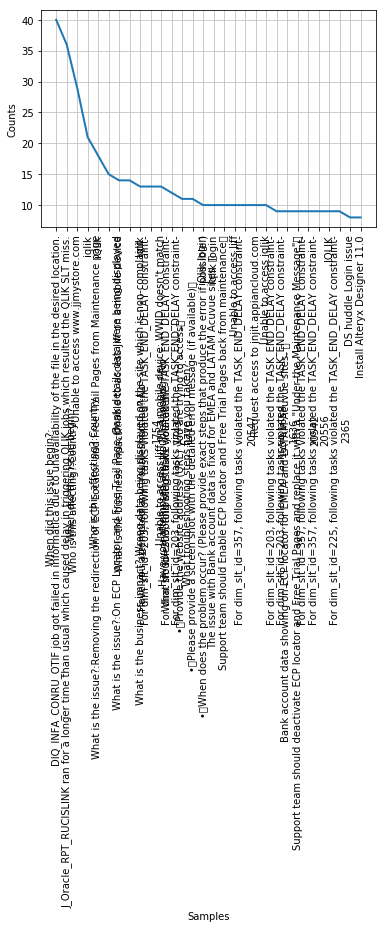

In [46]:
count = nltk.FreqDist(data.Description.values)
count.plot(30)

In [47]:
final_doc = data['Description']
all_documents = tuple(final_doc)

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(all_documents)
print (tfidf_matrix.shape)
print(tfidf_matrix)

(29239, 53377)
  (0, 48977)	0.5618743294326463
  (0, 30070)	0.3090704917470208
  (0, 44559)	0.24186789544011186
  (0, 52711)	0.1277174065935419
  (0, 44198)	0.25324798382041364
  (0, 52810)	0.17421708301803615
  (0, 38376)	0.647668681456686
  (1, 52810)	0.19358374309702978
  (1, 36403)	0.2723072078884552
  (1, 33342)	0.18169589388748966
  (1, 19813)	0.2881747203242772
  (1, 33345)	0.19781746799797503
  (1, 7340)	0.4571937644719277
  (1, 35766)	0.303245243650721
  (1, 49592)	0.10528509354614628
  (1, 35981)	0.18726749009324783
  (1, 35959)	0.24979593810446385
  (1, 25009)	0.5689010550831536
  (2, 36403)	0.10112241714360008
  (2, 33342)	0.13494705569818297
  (2, 19813)	0.21402976810521157
  (2, 33345)	0.14692068324079113
  (2, 36392)	0.13521393416245645
  (2, 50363)	0.1504213063813408
  (2, 52141)	0.1392987940610721
  :	:
  (29237, 29191)	0.2839103312087499
  (29237, 30724)	0.2822367322842236
  (29237, 33284)	0.2881078253475096
  (29237, 39135)	0.2839103312087499
  (29237, 32434)	0.37219

In [49]:
reindexed_data= data["Description"]

data_text = data[['Description']]
data_text['index'] = data_text.index
documents=data_text


print(len(documents))
print(documents[:5])

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk


def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


29239
                                         Description  index
0  SIMS  blank page when open with IE\r\n??IE ??S...      0
1  For dim_slt_id=203, dim_task_id=1658 exited wi...      1
2  For DIM_SLT_ID=203, following task(s) violated...      2
4                            > DS huddle Login issue      4
6  When did this issue begin?:2018-09-28\n\nWho i...      6


In [52]:
from nltk.stem.porter import *
stemmer = PorterStemmer()
stemmer.stem('identified')


doc_sample = documents[documents['index'] == 12].values[0][0]
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))


processed_docs = documents['Description'].map(preprocess)
processed_docs[:5]

original document: 
['For', 'DIM_SLT_ID=203,', 'following', 'task(s)', 'violated', 'the', 'TASK_END_DELAY', 'constraint-\n\nDIM_TASK_ID:', '1785\nTASK_NAME:', 's_m_MENTOR_INT_MNT_PROD_CUST_CONSIG\nSTART_TIME:', '2019-08-24', '08:24:00', 'UTC\nEND_TIME:', '2019-08-24', '08:25:00', 'UTC\n']


 tokenized and lemmatized document: 
['dim_slt_id', 'follow', 'task', 'violat', 'task_end_delay', 'constraint', 'dim_task_id', 'task_nam', 'start_tim', 'end_tim']


0                        [sim, blank, page, open, sim]
1    [dim_slt_id, dim_task_id, exit, statu, fail, f...
2    [dim_slt_id, follow, task, violat, task_end_de...
4                                 [huddl, login, issu]
6    [issu, begin, affect, sale, forc, issu, correc...
Name: Description, dtype: object

## LDA with Gensim:

### Create a dictionary from the data, then convert to bag-of-words corpus and save the dictionary and corpus for future use.

In [53]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 blank
1 open
2 page
3 sim
4 dim_slt_id
5 dim_task_id
6 exit
7 fact_run_id
8 fail
9 statu
10 constraint


In [54]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[123]

[(3, 1), (42, 2), (50, 1), (62, 1), (172, 1), (191, 1), (213, 1), (353, 1)]

In [55]:
#Preview Bag Of Words for our sample preprocessed document.
bow_doc_123 = bow_corpus[123]
for i in range(len(bow_doc_123)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_123[i][0], 
                                               dictionary[bow_doc_123[i][0]], 
bow_doc_123[i][1]))

Word 3 ("sim") appears 1 time.
Word 42 ("access") appears 2 time.
Word 50 ("error") appears 1 time.
Word 62 ("unabl") appears 1 time.
Word 172 ("attach") appears 1 time.
Word 191 ("get") appears 1 time.
Word 213 ("abl") appears 1 time.
Word 353 ("yesterday") appears 1 time.


In [56]:
#TF-IDF
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.436387232425874),
 (1, 0.32650974629601476),
 (2, 0.3065794432680233),
 (3, 0.7803631295203964)]


### Finding out 5 topics using LDA

In [57]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=5, id2word=dictionary, passes=2, workers=2)

In [58]:
# Print the results
import pickle

# Here we can assign topic names to each topic list, you can specify the number of words you want to have shown (e.g num_words = 5)
result = lda_model.print_topics(num_topics=5, num_words=5)
print(result)

for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

[(0, '0.043*"end" + 0.041*"null" + 0.037*"indic" + 0.032*"itsusralsp" + 0.029*"applic"'), (1, '0.028*"access" + 0.023*"applic" + 0.022*"iqlik" + 0.019*"tableau" + 0.017*"product"'), (2, '0.043*"indic" + 0.042*"end" + 0.028*"manag" + 0.028*"applic" + 0.028*"alert"'), (3, '0.043*"indic" + 0.043*"end" + 0.040*"itsusralsp" + 0.029*"manag" + 0.029*"null"'), (4, '0.042*"troubleshoot" + 0.026*"dim_task_id" + 0.025*"task_nam" + 0.024*"busi" + 0.023*"start_tim"')]
Topic: 0 
Words: 0.043*"end" + 0.041*"null" + 0.037*"indic" + 0.032*"itsusralsp" + 0.029*"applic" + 0.027*"alert" + 0.025*"manag" + 0.016*"node" + 0.016*"workload" + 0.016*"time"
Topic: 1 
Words: 0.028*"access" + 0.023*"applic" + 0.022*"iqlik" + 0.019*"tableau" + 0.017*"product" + 0.016*"unabl" + 0.015*"sale" + 0.014*"jira" + 0.013*"troubleshoot" + 0.011*"data"
Topic: 2 
Words: 0.043*"indic" + 0.042*"end" + 0.028*"manag" + 0.028*"applic" + 0.028*"alert" + 0.028*"null" + 0.019*"prod" + 0.017*"itsusralsp" + 0.015*"data" + 0.015*"awsahdn

In [59]:
# put these in a file and name the topics
with open("lda_topics_result.txt", "w") as f:
    for s in result:
        f.write(str(s) +"\n")

### pyLDAvis help to interpret the topics in a topic model that has been fit to a corpus of text data

In [60]:
# Visualize
import pyLDAvis.gensim

lda_display = pyLDAvis.gensim.prepare(lda_model, bow_corpus,dictionary, sort_topics=True)
pyLDAvis.display(lda_display)

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [61]:
from collections import OrderedDict

data_lda = {i: OrderedDict(lda_model.show_topic(i,25)) for i in range(5)}

In [62]:
import pandas as pd

df_lda = pd.DataFrame(data_lda)
print(df_lda.shape)
df_lda = df_lda.fillna(0).T
print(df_lda.shape)

(81, 5)
(5, 81)


In [63]:
df_lda

,access,address,affect,alert,alertgroup,alertprior,applic,apptech,aspac,attempt,...,tableau,take,task,task_nam,time,troubleshoot,unabl,violat,vital,workload
0,0.000000,0.000000,0.000000,0.026625,0.000000,0.015205,0.028907,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.016040,0.000000,0.000000,0.000000,0.01538,0.016221
1,0.027569,0.000000,0.000000,0.000000,0.000000,0.000000,0.023090,0.000000,0.010951,0.000000,...,0.018765,0.000000,0.000000,0.000000,0.007432,0.013500,0.016211,0.000000,0.00000,0.000000
2,0.000000,0.000000,0.000000,0.027941,0.000000,0.000000,0.028151,0.014199,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
3,0.000000,0.014502,0.000000,0.028670,0.014518,0.000000,0.028736,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
4,0.011063,0.000000,0.021703,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021139,...,0.000000,0.021383,0.011287,0.024833,0.000000,0.042076,0.005454,0.010006,0.00000,0.000000


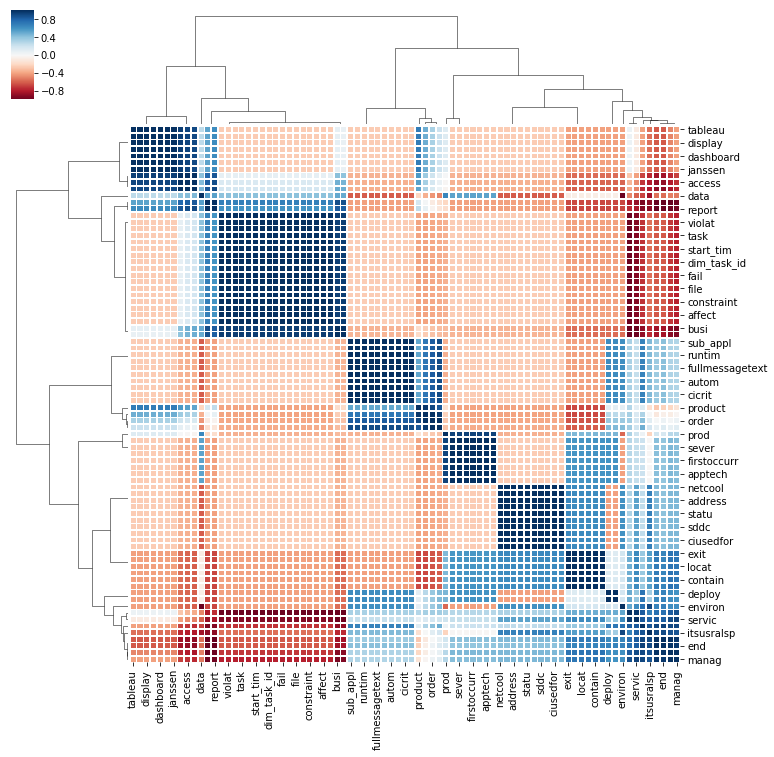

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

g=sns.clustermap(df_lda.corr(), center=0, cmap="RdBu", metric='cosine', linewidths=.75, figsize=(12, 12))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

In [65]:
MAX_LENGTH = 500
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data.Description.values)
post_seq = tokenizer.texts_to_sequences(data.Description.values)
post_seq_padded = pad_sequences(post_seq, maxlen=MAX_LENGTH)

In [66]:
def data_set_split (y):
    X_train, X_test, y_train, y_test = train_test_split(post_seq_padded, y, test_size=0.05,random_state=42)
    return X_train, X_test, y_train, y_test

In [67]:

vocab_size = len(tokenizer.word_index) + 1

## Deep Learning Model Simple

In [68]:
from sklearn.externals import joblib

In [69]:
def model_training(num_class, model_file):    
    inputs = Input(shape=(MAX_LENGTH, ))
    embedding_layer = Embedding(vocab_size,
                            128,
                            input_length=MAX_LENGTH)(inputs)
    x = Flatten()(embedding_layer)
    x = Dense(32, activation='relu')(x)
    predictions = Dense(num_class, activation='softmax')(x)
    model = Model(inputs=[inputs], outputs=predictions)
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])
    model.summary()
    checkpointer = ModelCheckpoint(model_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    history = model.fit([X_train], batch_size=124, y=to_categorical(y_train), verbose=1, validation_split=0.25, 
          shuffle=True, epochs=10, callbacks=[checkpointer])
    
    df = pd.DataFrame({'epochs':history.epoch, 'accuracy': history.history['acc'], 'validation_accuracy': history.history['val_acc']})
    g = sns.pointplot(x="epochs", y="accuracy", data=df, fit_reg=False)
    g = sns.pointplot(x="epochs", y="validation_accuracy", data=df, fit_reg=False, color='green')
    
    return model

### Training Model to predict Knowledge Article that could help to resolved the ticket

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 500)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 500, 128)          6758400   
_________________________________________________________________
flatten_1 (Flatten)          (None, 64000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2048032   
_________________________________________________________________
dense_2 (Dense)              (None, 6889)              227337    
Total params: 9,033,769
Trainable params: 9,033,769
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 208

['model-simple_KCS.pkl']

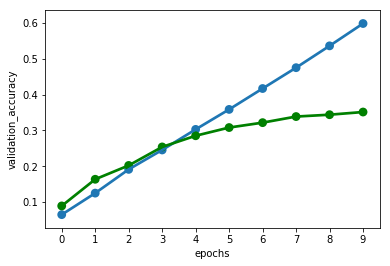

In [70]:
X_train, X_test, y_train, y_test = data_set_split(y_KCS)

model_file = 'weights-simple_KCS.hdf5'
model = model_training(num_class_KCS, model_file)
joblib.dump(model,'model-simple_KCS.pkl')

In [71]:
predicted = model.predict(X_test)
predicted = np.argmax(predicted, axis=1)
accuracy_score(y_test, predicted)

0.3707250341997264

In [72]:
# This utility function is from the sklearn docs: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)

In [73]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import itertools

In [74]:
# Use sklearn utility to convert label strings to numbered index
encoder = LabelEncoder()
#This should be adjusted to the Predictor
#encoder.fit(data.Resolution_category.values)
encoder.fit(data.KCS_solution.values)
text_labels = encoder.classes_ 


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


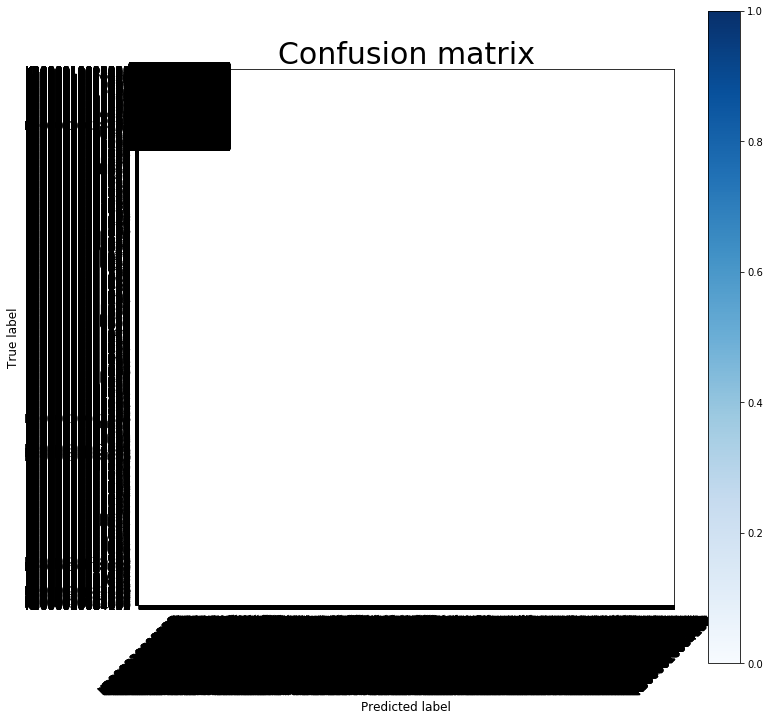

In [75]:
cnf_matrix = confusion_matrix(y_test, predicted)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()

## RNN with LSTM Layer

In [76]:
def lstm_model_training(num_class, model_file): 
    inputs = Input(shape=(MAX_LENGTH, ))
    embedding_layer = Embedding(vocab_size,
                                128,
                                input_length=MAX_LENGTH)(inputs)
    x = LSTM(64)(embedding_layer)
    x = Dense(32, activation='relu')(x)
    predictions = Dense(num_class, activation='softmax')(x)
    model_lstm = Model(inputs=[inputs], outputs=predictions)
    model_lstm.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['acc'])
    model_lstm.summary()

    checkpointer = ModelCheckpoint(model_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    history = model_lstm.fit([X_train], batch_size=64, y=to_categorical(y_train), verbose=1, validation_split=0.25, 
                             shuffle=True, epochs=20, callbacks=[checkpointer])
    
    df = pd.DataFrame({'epochs':history.epoch, 'accuracy': history.history['acc'], 'validation_accuracy': history.history['val_acc']})
    g = sns.pointplot(x="epochs", y="accuracy", data=df, fit_reg=False)
    g = sns.pointplot(x="epochs", y="validation_accuracy", data=df, fit_reg=False, color='green')
    return model_lstm


### Training Predictor for Knowledge Article using LSTM RNN 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 500)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 500, 128)          6758400   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 6889)              227337    
Total params: 7,037,225
Trainable params: 7,037,225
Non-trainable params: 0
_________________________________________________________________
Train on 20832 samples, validate on 6945 samples
Epoch 1/20
20832/20832 [==============================] - 138s 7ms/step - loss: 7.4

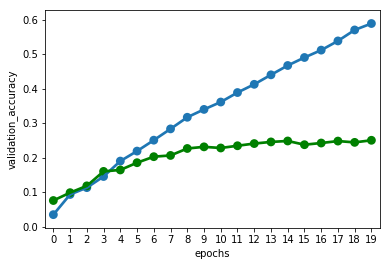

In [78]:
X_train, X_test, y_train, y_test = data_set_split(y_KCS)
model_lstm = lstm_model_training(num_class_KCS,"weights_KCS.hdf5")
joblib.dump(model_lstm,'model_KCS.pkl')
predicted = model_lstm.predict(X_test)

In [ ]:
predicted
predicted = np.argmax(predicted, axis=1)
accuracy_score(y_test, predicted)

In [ ]:
cnf_matrix = confusion_matrix(y_test, predicted)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted))